In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Models import *
from DDBSCAN import Raster_DBSCAN
import matplotlib.colors as mcolors
import cv2
from collections import defaultdict
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from scipy import stats
import seaborn as sns
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment
from filterpy.common import Q_discrete_white_noise
# times new roman font
plt.rcParams["font.family"] = "Times New Roman"
seed = 414
# np.random.seed(seed)
colors = np.random.rand(600, 3)
colors = np.concatenate([np.array([[0,0,0]]),colors],axis = 0)
colormap = mcolors.ListedColormap(colors)

In [413]:
patience = 5 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
lane_unit = 200
time_span = 100
hidden_size = 256
num_layers = 2
input_size = lane_unit
learning_rate = 0.001
num_epochs = 50
best_model = BidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# best_model = UnidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# criterion = RangeWeightedBCELoss()
# criterion = FocalLoss()
# criterion = sigmoid_focal_loss(reduction='mean')
# train2 16 epoch for 256
# train3 
mocel_save_path = r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\models\train_2"
if not os.path.exists(mocel_save_path):
    os.makedirs(mocel_save_path)
model_name = f'checkpoint_16.pth'
best_model.load_state_dict(torch.load(os.path.join(mocel_save_path, model_name),weights_only=False))
best_model.eval()
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[9,15],eps = 1,min_samples=1)


In [414]:
connection_pairs = [(0,1),(1,2),(2,3),(5,6)]
# identify chains in the connection_pairs and return the chain list
def identify_chains(connection_pairs):
    chains = []
    for pair in connection_pairs:
        if len(chains) == 0:
            chains.append(list(pair))
        else:
            pair_inserted = False
            for chain in chains:
                if pair[0] in chain:
                    chain.append(pair[1])
                    pair_inserted = True
                    break
                elif pair[1] in chain:
                    chain.append(pair[0])
                    pair_inserted = True
                    break
            if not pair_inserted:
                chains.append(list(pair))
    return chains
connection_pairs_ = identify_chains(connection_pairs)

In [415]:
def get_traj_labels(traj_dir,trajectory,time_space_diagram):
    # read labels in txt file in keypoint format for yolov8 and extract the keypoint coordinates
    lines = []
    with open(os.path.join(traj_dir,trajectory),'r') as f:
        for line in f:
            line = line.strip().split()
            line = [float(i) for i in line]
            lines.append(line)
    lines = np.array(lines)
    trajs_label = []
    # from index 8 of each row is the keypoint coordinates: something, x,y , something, x,y ...
    traj_type_label = []
    for line in lines:
        coords = []
        for i in range(5,len(line),3):
            coords.append((line[i],line[i+1]))
        coords = np.array(coords)
        coords[:,0] *= time_space_diagram.shape[1]
        coords[:,1] *= time_space_diagram.shape[0]
        traj = coords[coords[:,0].argsort()]
        trajs_label.append(traj)
        traj_type_label.append(line[0])
    return traj_type_label,trajs_label

def get_trajctories_dict_from_Label_map(Labels,time_span,center = True):
    trajectories_output = defaultdict(list)
    for t in range(time_span):
        Labels_t = Labels[:,t]
        unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
        if center:
            center_locations = xs + 0.5*counts
        else:
            center_locations = xs
        if unique_id[0] == -1:
            unique_id = unique_id[1:]
            center_locations = center_locations[1:]
        for i, label in enumerate(unique_id):
            trajectories_output[label].append((t,center_locations[i]))
    for key in trajectories_output.keys():
        traj = trajectories_output[key]
        trajectories_output[key] = np.array(traj)
    return trajectories_output

def get_trajs_from_LSTM_out(time_space_diagram,conf_thred = 0.35,time_span = 100, lane_unit = 200,center = True):
    pred_trajectories = time_space_diagram > conf_thred
    Labels = db.fit_predict(pred_trajectories, pred_trajectories)
    num_lane_units, time_span = time_space_diagram.shape
    trajectories_output = get_trajctories_dict_from_Label_map(Labels,time_span,center)
    # convert to list
    trajectories_output_ = []
    for key in trajectories_output.keys():
        traj = trajectories_output[key]
        trajectories_output_.append(traj)
    return trajectories_output_

def get_trajs_from_Kalman_out(time_space_diagram_input,time_span = 100):
    Labels = db.fit_predict(time_space_diagram_input> 0, time_space_diagram_input > 0)
    trajs_pred = get_trajctories_dict_from_Label_map(Labels,time_span,center = False)
    future_time_span = 25 # for kalmann filter
    connection_pairs = []
    for key in trajs_pred.keys():
        traj = np.array(trajs_pred[key])
        xs = traj[:,1]
        ts = traj[:,0]
        # interpolate the trajectory
        interpfunc = interp1d(ts, xs, kind='linear')
        ts = np.arange(ts[0],ts[-1]+1)
        xs = interpfunc(ts)
        f = KalmanFilter(dim_x=2, dim_z=1)
        f.x = np.array([[xs[0]],  # position
                        [0.]]) # velocity
        f.F = np.array([[1.,1.],
                        [0.,1.]])
        f.H = np.array([[1.,0.]])
        f.P *= 1000.
        f.R = 2000
        f.Q = 0.5
        kalman_traj = [[ts[0],xs[0]]]
        for i,t in enumerate(ts):
            f.predict()
            f.update(xs[i])
            kalman_traj.append([t,f.x[0][0]])

        find_connection_flag = False
        for t in range(ts[-1],ts[-1]+future_time_span):
            f.predict()
            for key_ in trajs_pred.keys():
                if key_ == key:
                    continue
                x_residual = np.abs(f.x[0][0] - trajs_pred[key_][0,1])
                t_residual =  trajs_pred[key_][0,0] - t 
                if x_residual < 2 and t_residual == 0:
                    connection_pairs.append((key,key_))
                    find_connection_flag = True
                    break
            if find_connection_flag:
                break
            kalman_traj.append([t,f.x[0][0]])
    trajs_pred_ = trajs_pred.copy()
    connection_pairs_ = identify_chains(connection_pairs)
    for chain in connection_pairs_:
        for i in range(1,len(chain)):
            try:
                trajs_pred_[chain[0]] = np.concatenate([trajs_pred_[chain[0]],trajs_pred_[chain[i]]],axis = 0)
                trajs_pred_.pop(chain[i])
            except:
                continue
    trajs_pred_ = [trajs_pred_[key] for key in trajs_pred_.keys()]

    return trajs_pred_

# evaluate 
speed_eva_window = 5
def get_traj_errors(trajs_label,trajs_pred,speed_eva_window = 5):
    speed_errors = []
    location_errors = []
    for i, traj_label in enumerate(trajs_label):
        for j, traj_pred in enumerate(trajs_pred.values()):
            if len(traj_pred) < speed_eva_window:
                continue
            # Extract time and x values
            t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
            # drop duplicate time points
            t_pred, indices = np.unique(t_pred, return_index=True)
            x_pred = x_pred[indices]
            t_label, x_label = traj_label[:, 0], traj_label[:, 1]
            # drop duplicate time points
            t_pred, indices = np.unique(t_label, return_index=True)
            x_label = x_label[indices]
            # Interpolate label trajectory to match pred trajectory time points
            interp_func = interp1d(t_label, x_label, fill_value="extrapolate")
            x_label_interp = interp_func(t_pred)
            
            # get the overlapping time span
            t_label_max,t_label_min = t_label[-1],t_label[0]
            t_pred_max,t_pred_min = t_pred[-1],t_pred[0]
            # if two trajectories have overlapping time span

            if t_pred_max < t_label_min or t_pred_min > t_label_max:
                continue
            overlap_start = max(t_pred_min,t_label_min)
            overlap_end = min(t_pred_max,t_label_max)
            x_label_interp_overlap = x_label_interp[(t_pred >= overlap_start) & (t_pred <= overlap_end)]
            x_pred_overlap = x_pred[(t_pred >= overlap_start) & (t_pred <= overlap_end)]
            # Calculate residuals
            residuals = x_pred_overlap - x_label_interp_overlap
            if len(residuals) == 0:
                continue
            location_error = np.mean(np.abs(residuals)) * 0.5 # meters
            
            if location_error < 1: # they are the same trajectory
      
                location_errors.append(location_error)            

                # calculate speed error
                speed_pred_curve = []
                speed_label_curve = []
                for k in range(len(residuals)-speed_eva_window):
                    speed_pred = (x_pred_overlap[k+speed_eva_window] - x_pred_overlap[k])*0.5 / (speed_eva_window/10)
                    speed_label = (x_label_interp_overlap[k+speed_eva_window] - x_label_interp_overlap[k])*0.5 / (speed_eva_window/10)
                    speed_pred_curve.append(speed_pred)
                    speed_label_curve.append(speed_label)
                speed_pred_curve = np.array(speed_pred_curve)
                speed_label_curve = np.array(speed_label_curve)
                if len(speed_pred_curve) == 0:
                    continue
                speed_error = np.mean(np.abs(speed_pred_curve - speed_label_curve)) # m/s
                if speed_error > 4:
                    print(location_error,speed_error, i,j)
                    plt.plot(x_label_interp_overlap,'b')
                    plt.plot(x_pred_overlap,'r')
                    plt.show()
                speed_errors.append(speed_error)
    return location_errors, speed_errors

def get_interpolated_traj(traj_label,traj_pred):
    t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
    # drop duplicate time points
    t_pred, indices = np.unique(t_pred, return_index=True)
    x_pred = x_pred[indices]
    t_label, x_label = traj_label[:, 0], traj_label[:, 1]
    # drop duplicate time points
    t_label, indices = np.unique(t_label, return_index=True)
    x_label = x_label[indices]
    # get the overlapping time span
    t_label_max,t_label_min = int(t_label.max()),int(t_label.min())
    t_pred_max,t_pred_min = int(t_pred.max()),int(t_pred.min())
   

    t_pred_ = np.arange(t_pred_min,t_pred_max+1)
    t_label_ = np.arange(t_label_min,t_label_max+1)
    # Interpolate label trajectory to match pred trajectory time points
    interp_func_label = interp1d(t_label, x_label, fill_value="extrapolate")
    interp_func_pred = interp1d(t_pred, x_pred, fill_value="extrapolate")
    x_label_interp = interp_func_label(t_pred_)
    x_pred_interp = interp_func_pred(t_label_)
    overlap_start = max(t_pred_min,t_label_min)
    overlap_end = min(t_pred_max,t_label_max)
    union_start = min(t_pred_min,t_label_min)
    union_end = max(t_pred_max,t_label_max)
    num_union = union_end - union_start + 1
    num_overlap = overlap_end - overlap_start + 1
    x_label_interp_overlap = x_label_interp[(t_pred_ >= overlap_start) & (t_pred_ <= overlap_end)]
    x_pred_interp_overlap = x_pred_interp[(t_label_ >= overlap_start) & (t_label_ <= overlap_end)]
    return t_pred_,t_label_,x_label_interp,x_pred_interp,x_label_interp_overlap,x_pred_interp_overlap,num_union,num_overlap,union_start,union_end,overlap_start,overlap_end

def get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = 1):
    TrajIoUMatrix = np.zeros((len(trajs_label),len(trajs_pred)))
    TrajPortionMatrix = np.zeros((len(trajs_label),len(trajs_pred)))
    for i, traj_label in enumerate(trajs_label):
        for j, traj_pred in enumerate(trajs_pred):
            # Extract time and x values
            t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
            t_label, x_label = traj_label[:, 0], traj_label[:, 1]
            # get the overlapping time span
            t_label_max,t_label_min = int(t_label.max()),int(t_label.min())
            t_pred_max,t_pred_min = int(t_pred.max()),int(t_pred.min())
            # if two trajectories have no overlapping time span, skip
            if t_pred_max < t_label_min or t_pred_min > t_label_max:
                continue
            t_pred_,t_label_,x_label_interp,x_pred_interp,x_label_interp_overlap,x_pred_interp_overlap,num_union,num_overlap,union_start,union_end,overlap_start,overlap_end = get_interpolated_traj(traj_label,traj_pred)
            
            x_label_interp_overlap = x_label_interp[(t_pred_ >= overlap_start) & (t_pred_ <= overlap_end)]
            x_pred_interp_overlap = x_pred_interp[(t_label_ >= overlap_start) & (t_label_ <= overlap_end)]
            residuals = np.abs(x_label_interp_overlap - x_pred_interp_overlap)
            if len(residuals) == 0:
                continue
            TrajIoUMatrix[i,j] = (residuals < x_error_threshold).sum() / num_overlap
            # how long the pred trajectory is in the label trajectory
            TrajPortionMatrix[i,j] = (residuals < x_error_threshold).sum() / num_overlap

    return TrajIoUMatrix,TrajPortionMatrix

def get_accuracy_metric(Iou_threshold, TrajIoUMatrix, TrajPortionMatrix, trajs_pred):
    pred_index = TrajIoUMatrix.argmax(axis = 1)
    pred_IoU = TrajIoUMatrix.max(axis = 1)
    tp, fp, fn, id_switch, discontinuity = 0, 0, 0, 0, 0
    for i,j in enumerate(pred_index):
        # i is the index of label trajectory, j is the index of pred trajectory
        IoU = pred_IoU[i]
        if IoU > Iou_threshold:
            tp += 1
        else:
            fn += 1
    
    for i in range(TrajIoUMatrix.shape[0]):
        if (TrajIoUMatrix[i] > 0).sum() > 1:
            discontinuity += 1
    for j in range(TrajIoUMatrix.shape[1]):
        if (TrajIoUMatrix[:,j] > 0).sum() > 1:
            id_switch += 1
    for j in range(TrajIoUMatrix.shape[1]):
        if j not in pred_index:
            if trajs_pred[j][0,1] > 5:
                fp += 1

    return tp, fp, fn, id_switch, discontinuity
def get_speed_spatial_error(trajs_label,trajs_pred,pred_index,pred_IoU,Iou_threshold,speed_eva_window,traj_type_label = None):
    acceleration_errors = []
    speed_errors = []
    spatial_errors = []
    occ_acceleration_errors = []
    occ_speed_errors = []
    occ_spatial_errors = []
    

    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold and len(trajs_pred[j]) > speed_eva_window + 1:
   

            traj_label = trajs_label[i]
            traj_pred = trajs_pred[j]
            t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
            t_label, x_label = traj_label[:, 0], traj_label[:, 1]
        # get the overlapping time span
            t_label_max,t_label_min = int(t_label.max()),int(t_label.min())
            t_pred_max,t_pred_min = int(t_pred.max()),int(t_pred.min())
            if t_pred_max < t_label_min or t_pred_min > t_label_max:
                continue
            t_pred_,t_label_,x_label_interp,x_pred_interp,x_label_interp_overlap,x_pred_interp_overlap,num_union,num_overlap,union_start,union_end,overlap_start,overlap_end =  get_interpolated_traj(traj_label,traj_pred)
            sptial_error = x_pred_interp_overlap - x_label_interp_overlap
            if traj_type_label[i] == 1:
                occ_spatial_errors.append(sptial_error)
            else:
                spatial_errors.append(sptial_error)
        # calculate speed error
            speed_pred_curve = []
            acceleration_pred_curve = []
            speed_label_curve = []
            acceleration_label_curve = []
            for k in range(len(sptial_error)-speed_eva_window):
                speed_pred_k = (x_pred_interp_overlap[k+speed_eva_window] - x_pred_interp_overlap[k])*0.5 / (speed_eva_window/10)
                speed_label_k = (x_label_interp_overlap[k+speed_eva_window] - x_label_interp_overlap[k])*0.5 / (speed_eva_window/10)
                speed_pred_k_ = (x_pred_interp_overlap[k+speed_eva_window-1] - x_pred_interp_overlap[k-1])*0.5 / (speed_eva_window/10)
                speed_label_k_ = (x_label_interp_overlap[k+speed_eva_window-1] - x_label_interp_overlap[k-1])*0.5 / (speed_eva_window/10)
                acceleration_pred_k = speed_pred_k - speed_pred_k_
                acceleration_label_k = speed_label_k - speed_label_k_
                
                speed_pred_curve.append(speed_pred_k)
                speed_label_curve.append(speed_label_k)
                acceleration_pred_curve.append(acceleration_pred_k)
                acceleration_label_curve.append(acceleration_label_k)
            
            speed_pred_curve = np.array(speed_pred_curve)
            speed_label_curve = np.array(speed_label_curve)
            acceleration_pred_curve = np.array(acceleration_pred_curve)
            acceleration_label_curve = np.array(acceleration_label_curve)
            
            speed_error = speed_pred_curve - speed_label_curve
            acceleration_error = acceleration_pred_curve - acceleration_label_curve
            if traj_type_label[i] == 0:
                occ_speed_errors.append(speed_error)
                occ_acceleration_errors.append(acceleration_error)
            else:
                speed_errors.append(speed_error)
                acceleration_errors.append(acceleration_error)
            # speed_errors.append(speed_error)
    
    if len(speed_errors) == 0:
        speed_errors = np.array([])
    else:
        speed_errors = np.concatenate(speed_errors)
    if len(spatial_errors) == 0:
        spatial_errors = np.array([])
    else:
        spatial_errors = np.concatenate(spatial_errors)
    if len(occ_speed_errors) == 0:
        occ_speed_errors = np.array([])
    else:
        occ_speed_errors = np.concatenate(occ_speed_errors)
    if len(occ_spatial_errors) == 0:
        occ_spatial_errors = np.array([])
    else:
        occ_spatial_errors = np.concatenate(occ_spatial_errors)
    if len(acceleration_errors) == 0:
        acceleration_errors = np.array([])
    else:
        acceleration_errors = np.concatenate(acceleration_errors)
    if len(occ_acceleration_errors) == 0:
        occ_acceleration_errors = np.array([])
    else:
        occ_acceleration_errors = np.concatenate(occ_acceleration_errors)
    return speed_errors,spatial_errors,occ_speed_errors,occ_spatial_errors,acceleration_errors,occ_acceleration_errors


# Manual Dataset Evaluation

## LSTM Method

In [403]:
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2330\TimeSpace 2.v2i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2330\TimeSpace 2.v2i.yolov8\train\labels'
# raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2330\lane_2.npy')
img_out_folder = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2330\TimeSpace 2.v2i.yolov8\train\pred_out'
time_span = 100
lane_unit_num = 200
x_error_threshold = 4
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[11,19],eps = 1,min_samples=3)

time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
Iou_threshold = 0.8
total_tps, total_fps, total_fns = [], [], []
total_discontinuities, total_switches = [], []
total_speed_errors, total_spatial_errors = [], []
total_recovered_trajs = []
for conf_thred in np.arange(0.2,0.9,0.05):
    total_tp, total_fp, total_fn = 0, 0, 0
    total_switch,total_discontinuity = 0,0
    recovered_traj = 0
    for frame_ind in tqdm(range(len(time_space_diagram_list))):
        time_space_diagram_name = time_space_diagram_list[frame_ind]
        trajectory_name = trajectory_list[frame_ind]
        time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

        traj_type_label,trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)

        time_space_diagram_input = time_space_diagram_raw > 100
        time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
        original_shape = time_space_diagram_input.shape
        padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
        time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
        
        with torch.no_grad():
            input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
            input_snippet = input_snippet.unsqueeze(0)
            output = best_model(input_snippet)
            output = output.squeeze(0).cpu().numpy()
        output[125:] = 0
        trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)
        if len(trajs_pred) == 0:
            total_fn += len(trajs_label)
            continue
        # trajs_label = [traj for i, traj in enumerate(trajs_label) if traj_type_label[i] == 0] # for only occlusion evaluation
        TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
        tp,fp,fn,id_switch,discontinuity = get_accuracy_metric(Iou_threshold, TrajIoUMatrix, TrajPortionMatrix, trajs_pred)
        
        pred_index = TrajIoUMatrix.argmax(axis = 1)
        pred_IoU = TrajIoUMatrix.max(axis = 1)
        speed_errors,spatial_errors = get_speed_spatial_error(trajs_label,trajs_pred,pred_index,pred_IoU,Iou_threshold,speed_eva_window)

        total_tp += tp
        total_fp += fp
        total_fn += fn
        total_switch += id_switch
        total_discontinuity += discontinuity
        total_speed_errors.append(speed_errors)
        total_spatial_errors.append(spatial_errors)
        trajs_label = [traj for i, traj in enumerate(trajs_label) if traj_type_label[i] == 0] # for only occlusion evaluation
        TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
        tp,fp,fn,id_switch,discontinuity = get_accuracy_metric(Iou_threshold, TrajIoUMatrix, TrajPortionMatrix, trajs_pred)
        recovered_traj += tp
    
    total_tps.append(total_tp)
    total_fps.append(total_fp)
    total_fns.append(total_fn)
    total_switches.append(total_switch)
    total_discontinuities.append(total_discontinuity)
    total_recovered_trajs.append(recovered_traj)

df = pd.DataFrame({'ConfThred':np.arange(0.2,0.9,0.05),'TP':total_tps,'FP':total_fps,'FN':total_fns, 'IDSwitch':total_switches,'Discontinuity':total_discontinuities,'RecoveredTrajs':total_recovered_trajs})
df['precision'] = df['TP'] / (df['TP'] + df['FP'])
df['recall'] = df['TP'] / (df['TP'] + df['FN'])
df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
# df.to_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_manual_256.csv',index = False)

  0%|          | 0/325 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

In [149]:
df.to_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_manual_256.csv',index = False)

In [30]:
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2330\TimeSpace 2.v2i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2330\TimeSpace 2.v2i.yolov8\train\labels'
# raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2330\lane_2.npy')
img_out_folder = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2330\TimeSpace 2.v2i.yolov8\train\pred_out'
time_span = 100
lane_unit_num = 200
x_error_threshold = 4


In [411]:
total_tp, total_fp, total_fn = 0, 0, 0
total_switch,total_discontinuity = 0,0
conf_thred = 0.4
total_speed_errors = []
total_spatial_errors = []
total_occ_speed_errors = []
total_occ_spatial_errors = []
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
Iou_threshold = 0.8
total_tps, total_fps, total_fns = [], [], []
total_discontinuities, total_switches = [], []
total_speed_errors, total_spatial_errors = [], []
total_occ_speed_errors, total_occ_spatial_errors = [], []
total_occ_acceleration_errors = []
total_acceleration_errors = []
total_recovered_trajs = []
speed_eva_window = 20
x_error_threshold = 2
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[11,19],eps = 1,min_samples=1)

for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

    traj_type_label,trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)

    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    original_shape = time_space_diagram_input.shape
    padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
    time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
    with torch.no_grad():
        input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
        input_snippet = input_snippet.unsqueeze(0)
        output = best_model(input_snippet)
        output = output.squeeze(0).cpu().numpy()
    output[125:] = 0
    trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)
    if len(trajs_pred) == 0:
        total_fn += len(trajs_label)
        continue
    trajs_label = [traj for i, traj in enumerate(trajs_label) if traj_type_label[i] == 0] # for only occlusion evaluation
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    
    tp,fp,fn,id_switch,discontinuity = get_accuracy_metric(Iou_threshold, TrajIoUMatrix, TrajPortionMatrix, trajs_pred)
    
    pred_index = TrajIoUMatrix.argmax(axis = 1)
    pred_IoU = TrajIoUMatrix.max(axis = 1)
    
    speed_errors,spatial_errors,occ_speed_errors,occ_spatial_errors,acceleration_errors,occ_acceleration_errors = get_speed_spatial_error(trajs_label,trajs_pred,pred_index,pred_IoU,Iou_threshold,speed_eva_window,traj_type_label)
    # occ_speed_errors, occ_spatial_errors = get_speed_spatial_error(trajs_label,trajs_pred,pred_index,pred_IoU,Iou_threshold,speed_eva_window,traj_type_label)
    total_tp += tp
    total_fp += fp
    total_fn += fn
    total_switch += id_switch
    total_discontinuity += discontinuity
    total_speed_errors.append(speed_errors)
    total_spatial_errors.append(spatial_errors)
    total_occ_speed_errors.append(occ_speed_errors)
    total_occ_spatial_errors.append(occ_spatial_errors)
    total_occ_acceleration_errors.append(occ_acceleration_errors)
    total_acceleration_errors.append(acceleration_errors)
    
total_occ_spatial_errors_LSTM = np.concatenate(total_occ_spatial_errors)
total_occ_speed_errors_LSTM = np.concatenate(total_occ_speed_errors)
total_speed_errors_LSTM = np.concatenate(total_speed_errors)
total_spatial_errors_LSTM = np.concatenate(total_spatial_errors)
total_acceleration_errors_LSTM = np.concatenate(total_acceleration_errors)
total_occ_acceleration_errors_LSTM = np.concatenate(total_occ_acceleration_errors)


100%|██████████| 325/325 [00:07<00:00, 42.48it/s]


In [412]:
total_tp

507

In [410]:
print(total_tp,total_fp,total_fn,total_switch,total_discontinuity)

1357 152 121 11 39


In [408]:
print(total_tp,total_fp,total_fn,total_switch,total_discontinuity)

1324 115 154 21 15


In [405]:
total_occ_spatial_errors_LSTM.mean(),total_spatial_errors_LSTM.mean(),total_occ_speed_errors_LSTM.mean(),total_speed_errors_LSTM.mean(),total_occ_acceleration_errors_LSTM.mean(),total_acceleration_errors_LSTM.mean()

(0.6054534342060213,
 0.8088220629393121,
 0.002366136891137263,
 0.013456917527861269,
 0.000851443035390029,
 0.0017060931842925726)

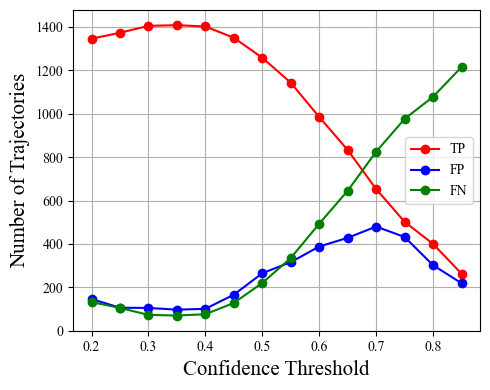

In [151]:
# plot precision recall curve and F1 score curve with different confidence threshold in same canvas, please make it beautiful
plt.figure(figsize=(5,4))
plt.grid()
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['TP'],label = 'TP', color = 'r', marker = 'o')
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['FP'],label = 'FP', color = 'b', marker = 'o')
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['FN'],label = 'FN', color = 'g', marker = 'o')
plt.xlabel('Confidence Threshold',fontsize = 15)
plt.ylabel('Number of Trajectories',fontsize = 15)
plt.ylim(0,1478)
plt.legend()
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_manual_256.png',dpi = 300)
plt.show()

In [84]:
acc_eva_df.columns

Index(['ConfThred', 'TP', 'FP', 'FN', 'IDSwitch', 'Discontinuity',
       'RecoveredTrajs', 'precision', 'recall', 'F1'],
      dtype='object')

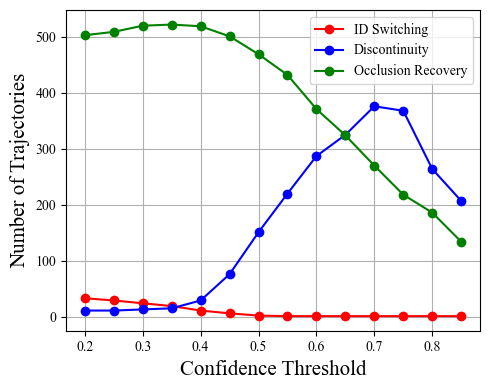

In [152]:
# plot precision recall curve and F1 score curve with different confidence threshold in same canvas, please make it beautiful
plt.figure(figsize=(5,4))
plt.grid()
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['IDSwitch'],label = 'ID Switching', color = 'r', marker = 'o')
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['Discontinuity'],label = 'Discontinuity', color = 'b', marker = 'o')
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['RecoveredTrajs'],label = 'Occlusion Recovery', color = 'g', marker = 'o')
plt.xlabel('Confidence Threshold',fontsize = 15)
plt.ylabel('Number of Trajectories',fontsize = 15)
# plt.ylim(0,1400)
plt.legend()
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_traj_metric_256.png',dpi = 300)
plt.show()

### DBSCAN

In [44]:
total_tp, total_fp, total_fn = 0, 0, 0
total_switch,total_discontinuity = 0,0
total_speed_errors, total_spatial_errors = [], []
total_occ_speed_errors, total_occ_spatial_errors = [], [] 
total_occ_acceleration_errors = []
total_acceleration_errors = []
total_recovered_trajs = []
speed_eva_window = 20
x_error_threshold = 2

db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[7,15],eps = 1,min_samples=1)
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

    traj_type_label,trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)


    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    
    trajs_pred = get_trajs_from_LSTM_out(time_space_diagram_input,conf_thred = conf_thred,time_span = 100, lane_unit = 200,center=False)
    # plt.figure(figsize=(6,5))
    # plt.imshow(time_space_diagram_input,cmap='gray', aspect = 'auto')
    # # plt.title('Prediction Confidence Map (Confidence Threshold = 0.7)',fontsize = 13)
    # for i,traj in enumerate(trajs_pred):
    #     t, x = zip(*traj)
    #     plt.plot(t,x,label = f'pred_{i}', linewidth = 10,alpha = 0.7)
    # # plt.ylim(100)
    # plt.xlabel('Time (0.1 sec)',fontsize = 13)
    # plt.ylabel('Lane Cell (0.5m)',fontsize = 13)
    # plt.xticks(fontsize = 13)
    # plt.yticks(fontsize = 13)
    # # plt.colorbar()
    # plt.legend(loc = 'lower left')
    # plt.tight_layout()
    # plt.savefig(f'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\DBSCANResult\{frame_ind}.png',dpi = 300)
    # plt.close()
    # # plt.show()
    # print(frame_ind)
    if len(trajs_pred) == 0:
        total_fn += len(trajs_label)
        continue
    # trajs_label = [traj for i, traj in enumerate(trajs_label) if traj_type_label[i] == 0]

    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    pred_index = TrajIoUMatrix.argmax(axis = 1)
    pred_IoU = TrajIoUMatrix.max(axis = 1)

    tp,fp,fn,id_switch,discontinuity = get_accuracy_metric(Iou_threshold, TrajIoUMatrix, TrajPortionMatrix, trajs_pred)
    speed_errors,spatial_errors,occ_speed_errors,occ_spatial_errors,acceleration_errors,occ_acceleration_errors = get_speed_spatial_error(trajs_label,trajs_pred,pred_index,pred_IoU,Iou_threshold,speed_eva_window,traj_type_label)
    total_tp += tp
    total_fp += fp
    total_fn += fn
    total_switch += id_switch
    total_discontinuity += discontinuity
    total_speed_errors.append(speed_errors)
    total_spatial_errors.append(spatial_errors)
    total_occ_speed_errors.append(occ_speed_errors)
    total_occ_spatial_errors.append(occ_spatial_errors)
    total_occ_acceleration_errors.append(occ_acceleration_errors)
    total_acceleration_errors.append(acceleration_errors)
    # break
# print(total_tp,total_fp,total_fn,total_switch,total_discontinuity)
total_occ_spatial_errors_DBSCAN = np.concatenate(total_occ_spatial_errors)
total_occ_speed_errors_DBSCAN = np.concatenate(total_occ_speed_errors)
total_speed_errors_DBSCAN = np.concatenate(total_speed_errors)
total_spatial_errors_DBSCAN = np.concatenate(total_spatial_errors)
total_acceleration_errors_DBSCAN = np.concatenate(total_acceleration_errors)
total_occ_acceleration_errors_DBSCAN = np.concatenate(total_occ_acceleration_errors)
# print(total_occ_speed_errors.mean(),total_occ_spatial_errors.mean(),total_speed_errors.mean(),total_spatial_errors.mean())

  0%|          | 0/325 [00:00<?, ?it/s]c:\Users\zhChe\anaconda3\envs\pygame\lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|██████████| 325/325 [00:06<00:00, 47.98it/s]


In [45]:
total_occ_spatial_errors_DBSCAN.mean(),total_spatial_errors_DBSCAN.mean(),total_occ_speed_errors_DBSCAN.mean(),total_speed_errors_DBSCAN.mean(),total_occ_acceleration_errors_DBSCAN.mean(),total_acceleration_errors_DBSCAN.mean()

(0.2706923653952416,
 0.6105574378752617,
 0.01103713048464103,
 0.00986729213774141,
 0.007951648896628971,
 0.0013993946279585664)

## Kalman Filter

In [46]:
total_tp, total_fp, total_fn = 0, 0, 0
total_switch,total_discontinuity = 0,0
total_speed_errors, total_spatial_errors = [], []
total_occ_speed_errors, total_occ_spatial_errors = [], []
total_occ_acceleration_errors = []
total_acceleration_errors = []
total_recovered_trajs = []
speed_eva_window = 20
x_error_threshold = 2
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[7,15],eps = 1,min_samples=1)
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)
    traj_type_label,trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)
    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    Labels = db.fit_predict(time_space_diagram_input> 0, time_space_diagram_input > 0)
    trajs_pred = get_trajs_from_Kalman_out(time_space_diagram_input,time_span = 100)
    # plt.figure(figsize=(6,5))
    # plt.imshow(time_space_diagram_input,cmap='gray', aspect = 'auto')
    # # plt.title('Prediction Confidence Map (Confidence Threshold = 0.7)',fontsize = 13)
    # for i,traj in enumerate(trajs_pred):
    #     t, x = zip(*traj)
    #     plt.plot(t,x,label = f'pred_{i}', linewidth = 10,alpha = 0.7)
    # # plt.ylim(100)
    # plt.xlabel('Time (0.1 sec)',fontsize = 13)
    # plt.ylabel('Lane Cell (0.5m)',fontsize = 13)
    # plt.xticks(fontsize = 13)
    # plt.yticks(fontsize = 13)
    # # plt.colorbar()
    # plt.legend(loc = 'lower left')
    # plt.tight_layout()
    # plt.savefig(f'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\Kalman\{frame_ind}.png',dpi = 300)
    # plt.close()
    if len(trajs_pred) == 0:
        total_fn += len(trajs_label)
        continue
    # trajs_label = [traj for i, traj in enumerate(trajs_label) if traj_type_label[i] == 0]
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    pred_index = TrajIoUMatrix.argmax(axis = 1)
    pred_IoU = TrajIoUMatrix.max(axis = 1)

    tp,fp,fn,id_switch,discontinuity = get_accuracy_metric(Iou_threshold, TrajIoUMatrix, TrajPortionMatrix, trajs_pred)
        
    speed_errors,spatial_errors,occ_speed_errors,occ_spatial_errors,acceleration_errors,occ_acceleration_errors = get_speed_spatial_error(trajs_label,trajs_pred,pred_index,pred_IoU,Iou_threshold,speed_eva_window,traj_type_label)
    total_tp += tp
    total_fp += fp
    total_fn += fn
    total_switch += id_switch
    total_discontinuity += discontinuity
    total_speed_errors.append(speed_errors)
    total_spatial_errors.append(spatial_errors)
    total_occ_speed_errors.append(occ_speed_errors)
    total_occ_spatial_errors.append(occ_spatial_errors)
    total_occ_acceleration_errors.append(occ_acceleration_errors)
    total_acceleration_errors.append(acceleration_errors)

print(total_tp,total_fp,total_fn,total_switch,total_discontinuity)
total_occ_spatial_errors_Kalman = np.concatenate(total_occ_spatial_errors)
total_occ_speed_errors_Kalman = np.concatenate(total_occ_speed_errors)
total_speed_errors_Kalman = np.concatenate(total_speed_errors)
total_spatial_errors_Kalman = np.concatenate(total_spatial_errors)
total_acceleration_errors_Kalman = np.concatenate(total_acceleration_errors)
total_occ_acceleration_errors_Kalman = np.concatenate(total_occ_acceleration_errors)

  1%|          | 4/325 [00:00<00:08, 36.20it/s]c:\Users\zhChe\anaconda3\envs\pygame\lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|██████████| 325/325 [00:15<00:00, 20.34it/s]

1298 475 180 47 215


In [ ]:
total_spatial_errors_LSTM = np.concatenate([total_spatial_errors_LSTM, total_occ_spatial_errors_LSTM])
total_speed_errors_LSTM = np.concatenate([total_speed_errors_LSTM, total_occ_speed_errors_LSTM])
total_spatial_errors_DBSCAN = np.concatenate([total_spatial_errors_DBSCAN, total_occ_spatial_errors_DBSCAN])
total_speed_errors_DBSCAN = np.concatenate([total_speed_errors_DBSCAN, total_occ_speed_errors_DBSCAN])
total_spatial_errors_Kalman = np.concatenate([total_spatial_errors_Kalman, total_occ_spatial_errors_Kalman])
total_speed_errors_Kalman = np.concatenate([total_speed_errors_Kalman, total_occ_speed_errors_Kalman])
total_acceleration_errors_LSTM = np.concatenate([total_acceleration_errors_LSTM, total_occ_acceleration_errors_LSTM])
total_acceleration_errors_DBSCAN = np.concatenate([total_acceleration_errors_DBSCAN, total_occ_acceleration_errors_DBSCAN])
total_acceleration_errors_Kalman = np.concatenate([total_acceleration_errors_Kalman, total_occ_acceleration_errors_Kalman])

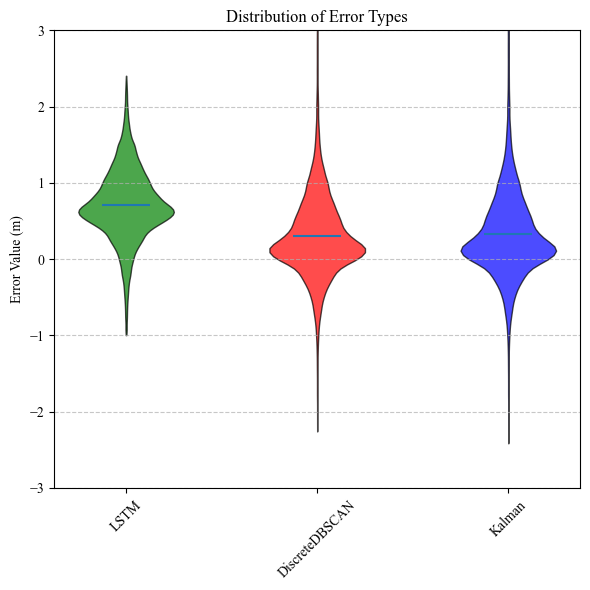

In [100]:
plt.rcParams['font.family'] = 'Times New Roman'
# Create a list of the arrays

mean_total_spatial_error_LSTM = np.mean(total_spatial_errors_LSTM)
mean_total_spatial_error_DBSCAN = np.mean(total_spatial_errors_DBSCAN)
mean_total_spatial_error_Kalman = np.mean(total_spatial_errors_Kalman)
std_total_spatial_error_LSTM = np.std(total_spatial_errors_LSTM)
std_total_spatial_error_DBSCAN = np.std(total_spatial_errors_DBSCAN)
std_total_spatial_error_Kalman = np.std(total_spatial_errors_Kalman)

# filter with 3 std
total_spatial_errors_LSTM_  = total_spatial_errors_LSTM[(total_spatial_errors_LSTM < mean_total_spatial_error_LSTM + 3 * std_total_spatial_error_LSTM) & (total_spatial_errors_LSTM > mean_total_spatial_error_LSTM - 3 * std_total_spatial_error_LSTM)]
total_spatial_errors_DBSCAN_  = total_spatial_errors_DBSCAN[(total_spatial_errors_DBSCAN < mean_total_spatial_error_DBSCAN + 3 * std_total_spatial_error_DBSCAN) & (total_spatial_errors_DBSCAN > mean_total_spatial_error_DBSCAN - 3 * std_total_spatial_error_DBSCAN)]
total_spatial_errors_Kalman_  = total_spatial_errors_Kalman[(total_spatial_errors_Kalman < mean_total_spatial_error_Kalman + 3 * std_total_spatial_error_Kalman) & (total_spatial_errors_Kalman > mean_total_spatial_error_Kalman - 3 * std_total_spatial_error_Kalman)]

data = [total_spatial_errors_LSTM_, total_spatial_errors_DBSCAN_, total_spatial_errors_Kalman_]
# Create labels for each distribution
labels = ['LSTM', 'DiscreteDBSCAN','Kalman']

# Set up the plot
plt.figure(figsize=(6, 6))

# Create the violin plot
parts = plt.violinplot(data, showextrema=False, showmeans=True)

# Customize the plot, use distinct colors, and rotate the labels 45 degrees
colors = ['green', 'red','blue']
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
# rotate the labels on x-axis with 45 degrees
plt.xticks(rotation=45)

# Customize median lines
# parts['cmedians'].set_color('black')

# Set labels and title
plt.xticks(range(1, len(labels) + 1), labels)
# plt.xlabel('Error Type')
plt.ylabel('Error Value (m)')
plt.title('Distribution of Error Types')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(-3,3)
# Show the plot
plt.tight_layout()
plt.show()



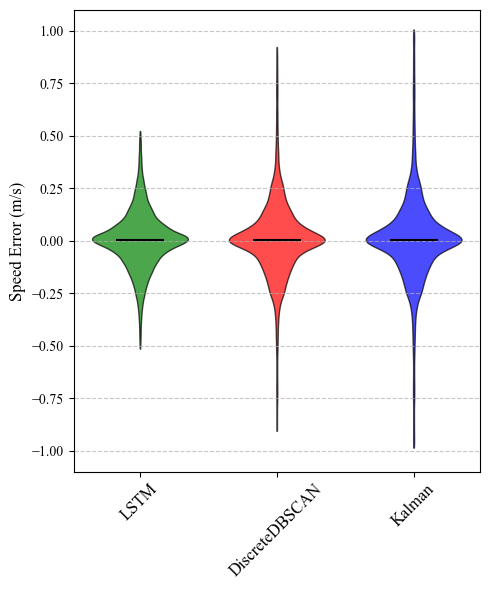

In [111]:
# use the same method to plot the speed error

mean_total_speed_error_LSTM = np.mean(total_speed_errors_LSTM)
mean_total_speed_error_DBSCAN = np.mean(total_speed_errors_DBSCAN)
mean_total_speed_error_Kalman = np.mean(total_speed_errors_Kalman)

std_total_speed_error_LSTM = np.std(total_speed_errors_LSTM)
std_total_speed_error_DBSCAN = np.std(total_speed_errors_DBSCAN)
std_total_speed_error_Kalman = np.std(total_speed_errors_Kalman)

# filter with 3 std

total_speed_errors_LSTM_  = total_speed_errors_LSTM[(total_speed_errors_LSTM < mean_total_speed_error_LSTM + 3 * std_total_speed_error_LSTM) & (total_speed_errors_LSTM > mean_total_speed_error_LSTM - 3 * std_total_speed_error_LSTM)]
total_speed_errors_DBSCAN_  = total_speed_errors_DBSCAN[(total_speed_errors_DBSCAN < mean_total_speed_error_DBSCAN + 3 * std_total_speed_error_DBSCAN) & (total_speed_errors_DBSCAN > mean_total_speed_error_DBSCAN - 3 * std_total_speed_error_DBSCAN)]
total_speed_errors_Kalman_  = total_speed_errors_Kalman[(total_speed_errors_Kalman < mean_total_speed_error_Kalman + 3 * std_total_speed_error_Kalman) & (total_speed_errors_Kalman > mean_total_speed_error_Kalman - 3 * std_total_speed_error_Kalman)]

data = [total_speed_errors_LSTM_, total_speed_errors_DBSCAN_,total_speed_errors_Kalman_]
# Create labels for each distribution
labels = ['LSTM', 'DiscreteDBSCAN','Kalman']
# Set up the plot
plt.figure(figsize=(5, 6))

# Create the violin plot
parts = plt.violinplot(data,showmedians=True, showextrema=False,points=1000, widths = 0.7)

# Customize the plot, use distinct colors, and rotate the labels 45 degrees
colors = ['green', 'red','blue']
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
# rotate the labels on x-axis with 45 degrees
plt.xticks(rotation=45, fontsize = 12)
# Customize median lines
parts['cmedians'].set_color('black')

# Set labels and title
plt.xticks(range(1, len(labels) + 1), labels)
# plt.xlabel('Error Type')
plt.ylabel('Speed Error (m/s)', fontsize = 12)
# plt.title('Speed Error Distribution',fontsize = 15)
plt.ylim(-1.1,1.1)
# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Show the plot
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\speed_error_distribution.png',dpi = 300)
plt.show()

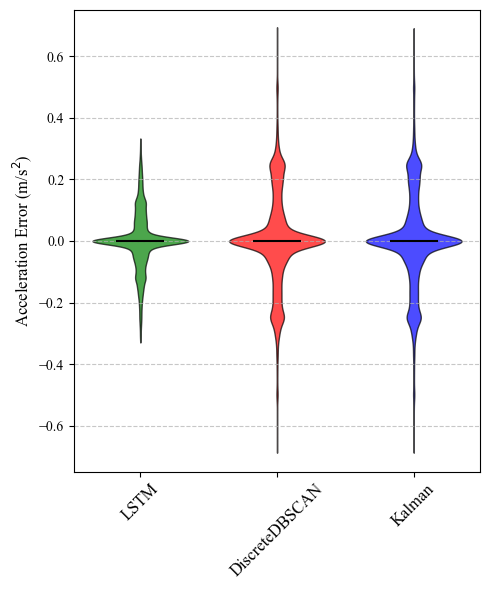

In [110]:
# use the same method to plot the acceleration error

mean_total_acceleration_error_LSTM = np.mean(total_acceleration_errors_LSTM)
mean_total_acceleration_error_DBSCAN = np.mean(total_acceleration_errors_DBSCAN)
mean_total_acceleration_error_Kalman = np.mean(total_acceleration_errors_Kalman)


std_total_acceleration_error_LSTM = np.std(total_acceleration_errors_LSTM)
std_total_acceleration_error_DBSCAN = np.std(total_acceleration_errors_DBSCAN)
std_total_acceleration_error_Kalman = np.std(total_acceleration_errors_Kalman)

# filter with 3 std
total_acceleration_errors_LSTM_  = total_acceleration_errors_LSTM[(total_acceleration_errors_LSTM < mean_total_acceleration_error_LSTM + 3 * std_total_acceleration_error_LSTM) & (total_acceleration_errors_LSTM > mean_total_acceleration_error_LSTM - 3 * std_total_acceleration_error_LSTM)]
total_acceleration_errors_DBSCAN_  = total_acceleration_errors_DBSCAN[(total_acceleration_errors_DBSCAN < mean_total_acceleration_error_DBSCAN + 3 * std_total_acceleration_error_DBSCAN) & (total_acceleration_errors_DBSCAN > mean_total_acceleration_error_DBSCAN - 3 * std_total_acceleration_error_DBSCAN)]
total_acceleration_errors_Kalman_  = total_acceleration_errors_Kalman[(total_acceleration_errors_Kalman < mean_total_acceleration_error_Kalman + 3 * std_total_acceleration_error_Kalman) & (total_acceleration_errors_Kalman > mean_total_acceleration_error_Kalman - 3 * std_total_acceleration_error_Kalman)]

data = [total_acceleration_errors_LSTM_, total_acceleration_errors_DBSCAN_,total_acceleration_errors_Kalman_]
# Create labels for each distribution
labels = [ 'LSTM', 'DiscreteDBSCAN','Kalman']

# Set up the plot
plt.figure(figsize=(5, 6))

# Create the violin plot
parts = plt.violinplot(data,showmedians=True, showextrema=False,points = 1000, widths = 0.7)

# Customize the plot, use distinct colors, and rotate the labels 45 degrees
colors = ['green', 'red', 'blue']
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
# rotate the labels on x-axis with 45 degrees
plt.xticks(rotation=45,fontsize = 12)
# Customize median lines
parts['cmedians'].set_color('black')

# Set labels and title
plt.xticks(range(1, len(labels) + 1), labels, fontsize = 12)
# plt.xlabel('Error Type')
# use math symbols for the ylabel showing the m/s^2
plt.ylabel('Acceleration Error (m/s$^2$)', fontsize = 12)
plt.ylim(-0.75,0.75)
# Add grid for better readability

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\acceleration_error_distribution.png',dpi = 300)
plt.show()


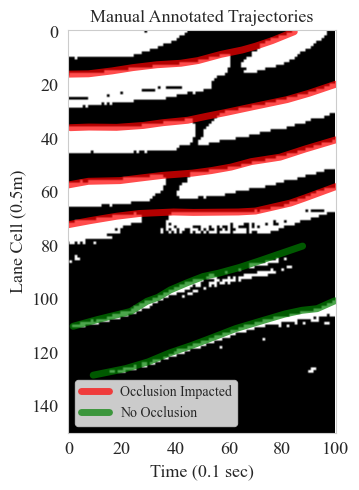

In [248]:
frame_ind = 112
time_space_diagram_name = time_space_diagram_list[frame_ind]
trajectory_name = trajectory_list[frame_ind]
time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

traj_type_label,trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)

db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[3,13],eps = 1,min_samples=3)
time_space_diagram_input = time_space_diagram_raw > 200
time_space_diagram_input = time_space_diagram_input.astype(np.uint8)

def legend_without_duplicate_labels(figure):
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc='lower left')

plt.figure(figsize=(6,5))
plt.imshow(time_space_diagram_input, cmap = 'gray')
# turn off the grid
plt.grid(False)
plt.title('Manual Annotated Trajectories',fontsize = 13)
for i,traj in enumerate(trajs_label):
    t, x = zip(*traj)
    if t[-1] - t[0] < 10:
        continue
    traj_type = traj_type_label[i]
    if traj_type == 0:
        plt.plot(t,x,label = 'Occlusion Impacted', linewidth = 5,alpha = 0.7, color = 'r')
    else:
        plt.plot(t,x,label = 'No Occlusion', linewidth = 5,alpha = 0.7, color = 'green')
    # plt.plot(t,x,label = 'Occlusion', linewidth = 10,alpha = 0.7)
plt.ylim(150)
plt.xlim(0,100)
plt.xlabel('Time (0.1 sec)',fontsize = 13)
plt.ylabel('Lane Cell (0.5m)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
# plt.colorbar()
legend_without_duplicate_labels(plt)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\ManualAnnotation.png',dpi = 300)
plt.show()

In [172]:
13 * 3600 / 1000

46.8

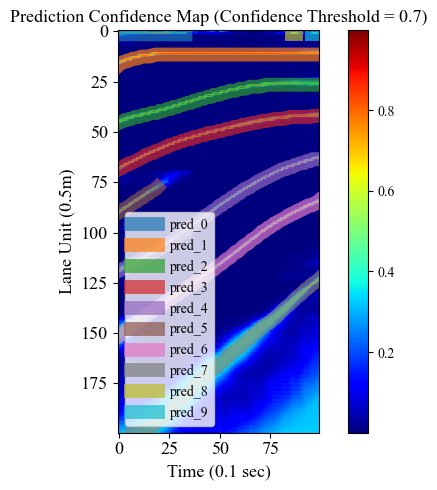

In [414]:
total_tp, total_fp, total_fn = 0, 0, 0
conf_thred = 0.35
frame_ind = 19
time_space_diagram_name = time_space_diagram_list[frame_ind]
trajectory_name = trajectory_list[frame_ind]
time_space_diagram_raw = cv2.imread(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2300\ManualImgs\11544.png', cv2.IMREAD_GRAYSCALE)

# trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[9,15],eps = 1,min_samples=1)

time_space_diagram_input = time_space_diagram_raw > 100
time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
original_shape = time_space_diagram_input.shape
padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
with torch.no_grad():
    input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
    input_snippet = input_snippet.unsqueeze(0)
    output = best_model(input_snippet)
    output = output.squeeze(0).cpu().numpy()
output = output[:original_shape[0]]
trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)

plt.figure(figsize=(6,5))
plt.imshow(output,cmap='jet')
plt.title('Prediction Confidence Map (Confidence Threshold = 0.7)',fontsize = 13)
for i,traj in enumerate(trajs_pred):
    t, x = zip(*traj)
   
    plt.plot(t,x,label = f'pred_{i}', linewidth = 10,alpha = 0.7)
# plt.ylim(100)
plt.xlabel('Time (0.1 sec)',fontsize = 13)
plt.ylabel('Lane Unit (0.5m)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.colorbar()
plt.legend(loc = 'lower left')
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\pred_confidence_map_0.7.png',dpi = 300)
plt.show()


In [245]:
occlusion_figure_output = r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\Occlusion'
conf_thred = 0.35
for frame_ind in range(len(time_space_diagram_list)):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

    trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)

    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    original_shape = time_space_diagram_input.shape
    padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
    time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
    with torch.no_grad():
        input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
        input_snippet = input_snippet.unsqueeze(0)
        output = best_model(input_snippet)
        output = output.squeeze(0).cpu().numpy()
    output = output[:original_shape[0]]
    trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)

    plt.figure(figsize=(6,5))
    plt.imshow(time_space_diagram_input,cmap='jet')
    # plt.title('Prediction Confidence Map (Confidence Threshold = 0.35)',fontsize = 13)
    for i,traj in enumerate(trajs_pred):
        t, x = zip(*traj)
        if t[-1] - t[0] < 10:
            continue
        plt.plot(t,x,label = f'pred_{i}', linewidth = 10,alpha = 0.7)
    plt.ylim(100)
    plt.xlabel('Time (0.1 sec)',fontsize = 13)
    plt.ylabel('Lane Unit (0.5m)',fontsize = 13)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.colorbar()
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.savefig(os.path.join(occlusion_figure_output,f'{frame_ind}.png'),dpi = 300)
    plt.close()
    # plt.show()


# Sim Dataset & Manual Dataset Comparison

In [265]:
val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\val",time_span)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
train_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\train",time_span)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [266]:
vehicle_nums_val = []
vehicle_speed_val = []
batch_count = 0
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    vehicle_nums_val.append(len(np.unique(traj_id))-1)
    # find mask where target is 1 and speed is not 0 and target is 1 and speed is 0
    mask = (target == 1) & (speed != 0)
    speeds = speed[mask].cpu().numpy()
    vehicle_speed_val.append(speeds)
    if batch_count >  5000:
        break
    batch_count += 1 
    # find the number of elements in mask
vehicle_nums_train = []
vehicle_speed_train = []
batch_count = 0
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    vehicle_nums_train.append(len(np.unique(traj_id))-1)
    # find mask where target is 1 and speed is not 0 and target is 1 and speed is 0
    mask = (target == 1) & (speed != 0)
    speeds = speed[mask].cpu().numpy()
    vehicle_speed_train.append(speeds)
    if batch_count >  5000:
        break
    batch_count += 1 
    # find the number of elements
vehicle_nums_val = np.array(vehicle_nums_val) / batch_size
vehicle_speed_val = np.concatenate(vehicle_speed_val)
vehicle_nums_train = np.array(vehicle_nums_train) / batch_size
vehicle_speed_train = np.concatenate(vehicle_speed_train)


  8%|▊         | 5001/61500 [06:09<1:09:33, 13.54it/s]


In [301]:
(vehicle_speed_val < 1.36).sum() / len(vehicle_speed_val)

0.37994895764769576

In [443]:
np.sum(vehicle_nums_manual) / len(vehicle_nums_manual)

4.547692307692308

In [441]:
vehicle_nums_manual = []
vehicle_speed_manual = []
vehicle_occu_manual = []
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)
    traj_type_label,trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)
    vehicle_nums_manual.append(len(trajs_label))
    vehicle_occu_manual.append(traj_type_label)
    for traj in trajs_label:
        traj = np.array(traj)
        t_label = traj[:,0]
        x_label = traj[:,1]

        unique_t = np.unique(t_label)
        t_label_ = np.arange(t_label.min(),t_label.max())
        x_label_interp_func = interp1d(t_label, x_label, kind='linear')
        x_label_interp = x_label_interp_func(t_label_)

        speed = -np.diff(x_label_interp) * 0.5 / (np.diff(t_label_) / 10)

        vehicle_speed_manual.append(speed)
vehicle_speed_manual = np.concatenate(vehicle_speed_manual)
vehicle_occu_manual = np.concatenate(vehicle_occu_manual)
# drop nan values
vehicle_nums_manual = np.array(vehicle_nums_manual)
        

100%|██████████| 325/325 [00:00<00:00, 1858.62it/s]


In [445]:
(vehicle_occu_manual == 0).sum() / np.sum(vehicle_nums_manual)

0.37077131258457374

In [309]:
(vehicle_occu_manual == 0).sum()/vehicle_nums_manual.sum()

0.11735330836454431

# Val Evaluations

In [577]:
batch_size = 1
total_tps, total_fps, total_fns = [], [], []
Iou_threshold = 0.8
for conf_thred in np.arange(0.2,0.9,0.05):
    val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\val",time_span)
    count = 0
    total_tp, total_fp, total_fn = 0, 0, 0

    for val_ind in tqdm(range(len(val_dataset))):
        batch = val_dataset[val_ind]

        if count > 2000:
            break
        post_occ_X = batch['post_occ_X'].to(device)
        target = batch['target'].to(device)
        speed = batch['speed_target'].to(device)
        traj_id = batch['traj_id']
        time_space_diagram_input = post_occ_X.unsqueeze(0)
        traj_id = traj_id.cpu().numpy()
        with torch.no_grad():
            input_snippet = time_space_diagram_input
            output = best_model(input_snippet)
            output = output.squeeze(0).cpu().numpy()
        trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)
        trajs_label = get_trajctories_dict_from_Label_map(traj_id,time_span)
        # convert trajs_label to list
        trajs_label = [trajs_label[i] for i in trajs_label.keys()]
        TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
        if TrajIoUMatrix.shape[1] == 0:
            # no detection
            total_fn += len(trajs_label)
            continue
        pred_index = TrajPortionMatrix.argmax(axis = 1)
        pred_IoU = []
        for i,j in enumerate(pred_index):
            pred_IoU.append(TrajIoUMatrix[i,j])
        pred_IoU = np.array(pred_IoU)
        # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
        tp, fp, fn = 0, 0, 0
        for i,j in enumerate(pred_index):
            if pred_IoU[i] >= Iou_threshold:
                tp += 1
            else:
                fn += 1

        for j in trajs_pred.keys():
            if trajs_pred[j][-1][1] > 100:
                continue
            if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
                continue
            if j not in pred_index:
                fp += 1
        # print(time_space_diagram_name)
        # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        total_tp += tp
        total_fp += fp
        total_fn += fn
        count += 1
    total_tps.append(total_tp)
    total_fps.append(total_fp)
    total_fns.append(total_fn)

df = pd.DataFrame({'ConfThred':np.arange(0.2,0.9,0.05),'TP':total_tps,'FP':total_fps,'FN':total_fns})
df['precision'] = df['TP'] / (df['TP'] + df['FP'])
df['recall'] = df['TP'] / (df['TP'] + df['FN'])
df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
df.to_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_val_128.csv',index = False)
    

  0%|          | 88/246000 [00:01<1:14:25, 55.07it/s]c:\Users\zhChe\anaconda3\envs\pygame\lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
  2%|▏         | 4004/246000 [01:30<1:30:57, 44.35it/s]


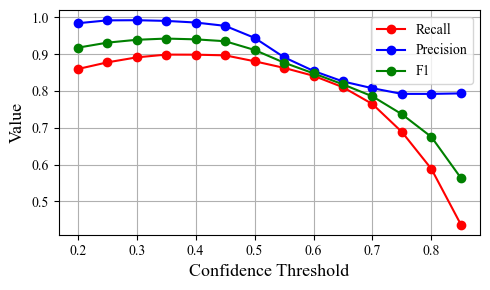

In [581]:
# plot precision recall curve and F1 score curve with different confidence threshold in same canvas, please make it beautiful
df_val = pd.read_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_val.csv')
plt.figure(figsize=(5,3))
plt.grid()
plt.plot(df_val['ConfThred'],df_val['recall'],label = 'Recall', color = 'r', marker = 'o')
plt.plot(df_val['ConfThred'],df_val['precision'],label = 'Precision', color = 'b', marker = 'o')
plt.plot(df_val['ConfThred'],df_val['F1'],label = 'F1', color = 'g', marker = 'o')
plt.xlabel('Confidence Threshold',fontsize = 13)
plt.ylabel('Value',fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_val_128.png',dpi = 300)
plt.show()

# Baseline Pure DBSCAN

In [557]:
total_tp, total_fp, total_fn = 0, 0, 0
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

    trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)


    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    
    trajs_pred = get_trajs_from_LSTM_out(time_space_diagram_input,conf_thred = conf_thred,time_span = 100, lane_unit = 200,center=False)
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    if TrajIoUMatrix.shape[1] == 0:
        # no detection
        total_fn += len(trajs_label)
        continue
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
    tp, fp, fn = 0, 0, 0
    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold:
            tp += 1
        else:
            fn += 1

    for j in trajs_pred.keys():
        if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
            continue
        if j not in pred_index:
            fp += 1
    # print(time_space_diagram_name)
    # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    total_tp += tp
    total_fp += fp
    total_fn += fn

100%|██████████| 109/109 [00:02<00:00, 51.51it/s]


In [558]:
precision = total_tp / (total_tp + total_fp)
recall = total_tp / (total_tp + total_fn)
F1 = 2 * precision * recall / (precision + recall)

In [559]:
(total_fp,total_fn,total_tp,precision,recall,F1)

(76, 135, 460, 0.8582089552238806, 0.773109243697479, 0.8134394341290893)

In [170]:
# get vehicle number and speed in time_space_diagram_list
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\labels'
raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy')
img_out_folder = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\pred_out'
time_span = 100
lane_unit_num = 200
x_error_threshold = 2
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
spatial_errors = []
speed_errors = []
speed_eva_window = 5
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)
    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    
    trajs_pred = get_trajs_from_LSTM_out(time_space_diagram_input,conf_thred = conf_thred,time_span = 100, lane_unit = 200,center=False)
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    if TrajIoUMatrix.shape[1] == 0:
        # no detection
        continue
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold and len(trajs_pred[j]) > speed_eva_window:
            traj_label = trajs_label[i]
            traj_pred = trajs_pred[j]
            x_label = traj_label[:,1]
            x_pred = traj_pred[:,1]
            t_label = traj_label[:,0]
            t_pred = traj_pred[:,0]
            # drop duplicate time points
            t_pred, indices = np.unique(t_pred, return_index=True)
            x_pred = x_pred[indices]
            t_label, indices = np.unique(t_label, return_index=True)
            x_label = x_label[indices]
            # Interpolate label trajectory to match pred trajectory time points
            interp_func = interp1d(t_label, x_label, fill_value="extrapolate")
            x_label_interp = interp_func(t_pred)
            sptial_error = np.abs(x_label_interp - x_pred) * 0.5
            spatial_errors.append(sptial_error)
            # calculate speed error
            speed_pred_curve = []
            speed_label_curve = []
            for k in range(len(sptial_error)-speed_eva_window):
                speed_pred = (x_pred[k+speed_eva_window] - x_pred[k])*0.5 / (speed_eva_window/10)
                speed_label = (x_label_interp[k+speed_eva_window] - x_label_interp[k])*0.5 / (speed_eva_window/10)
                speed_pred_curve.append(speed_pred)
                speed_label_curve.append(speed_label)
            speed_pred_curve = np.array(speed_pred_curve)
            speed_label_curve = np.array(speed_label_curve)
            speed_error = np.abs(speed_pred_curve - speed_label_curve)
            speed_errors.append(speed_error)

spatial_errors_DB = np.concatenate(spatial_errors)
speed_errors_DB = np.concatenate(speed_errors)          

100%|██████████| 109/109 [00:01<00:00, 65.91it/s]


In [561]:
val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\val",time_span)
count = 0
total_tp, total_fp, total_fn = 0, 0, 0

for val_ind in tqdm(range(len(val_dataset))):
    batch = val_dataset[val_ind]

    if count > 2000:
        break
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    time_space_diagram_input = post_occ_X.cpu().numpy()
    traj_id = traj_id.cpu().numpy()
    
    trajs_pred = get_trajs_from_LSTM_out(time_space_diagram_input,conf_thred = conf_thred,time_span = 100, lane_unit = 200,center=False)
    trajs_label = get_trajctories_dict_from_Label_map(traj_id,time_span)
    # convert trajs_label to list
    trajs_label = [trajs_label[i] for i in trajs_label.keys()]
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    if TrajIoUMatrix.shape[1] == 0:
        # no detection
        total_fn += len(trajs_label)
        continue
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
    tp, fp, fn = 0, 0, 0
    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold:
            tp += 1
        else:
            fn += 1

    for j in trajs_pred.keys():
        if trajs_pred[j][-1][1] > 100:
            continue
        if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
            continue
        if j not in pred_index:
            fp += 1
    # print(time_space_diagram_name)
    # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    total_tp += tp
    total_fp += fp
    total_fn += fn
    count += 1

  0%|          | 24/246000 [00:00<53:54, 76.05it/s]c:\Users\zhChe\anaconda3\envs\pygame\lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
  1%|          | 2001/246000 [00:36<1:13:59, 54.96it/s]


In [564]:
precision = total_tp / (total_tp + total_fp)
recall = total_tp / (total_tp + total_fn)
F1 = 2 * precision * recall / (precision + recall)

In [565]:
(total_fp,total_fn,total_tp,precision,recall,F1)

(2721,
 6684,
 1396,
 0.3390818557201846,
 0.17277227722772276,
 0.22890874805279987)

# Training Curve

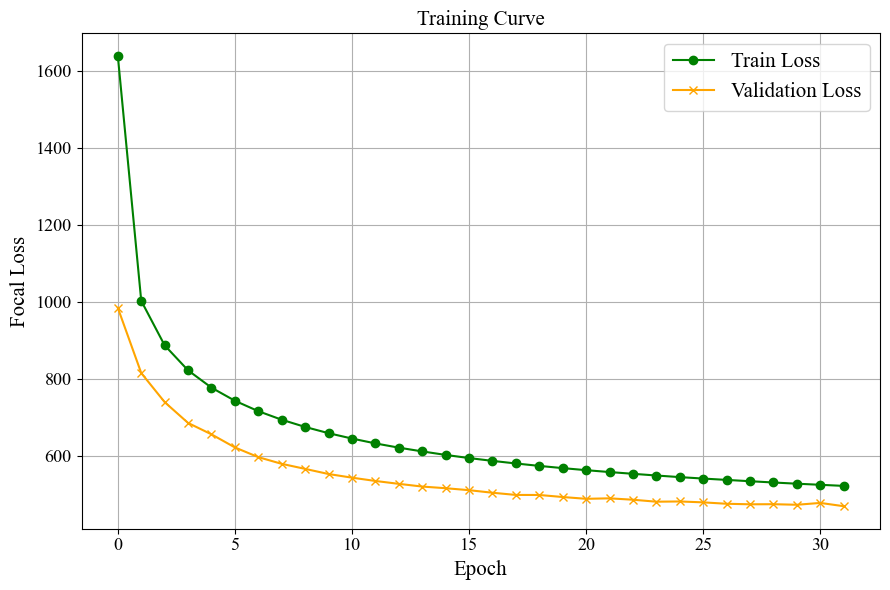

In [612]:
import json
curve_info_path = r'D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\models\train_3\training_curve.json'
with open(curve_info_path) as f:
    curve_info = json.load(f)
train_loss = curve_info['train_loss']
val_loss = curve_info['val_loss']
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)
plt.figure(figsize=(9,6))
plt.grid()
plt.plot(train_loss,label = 'Train Loss',color = 'green', marker = 'o')
plt.plot(val_loss,label = 'Validation Loss',color = 'orange', marker = 'x')
plt.xlabel('Epoch',fontsize = 15)
plt.ylabel('Focal Loss',fontsize = 15)
plt.title('Training Curve',fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 15)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\training_curve.png',dpi = 300)
plt.show()

## Case Study

In [181]:
stride = 1
TrafficContextDiagramFolder = r'D:\TimeSpaceDiagramDataset\9th&vir_314'
OutputFolder = r'D:\TimeSpaceDiagramDataset\9th&vir_314_pred'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
HalfhourPeriod = os.listdir(TrafficContextDiagramFolder) 
for period in HalfhourPeriod:
    LaneTCDlist = os.listdir(os.path.join(TrafficContextDiagramFolder,period))
    LaneTCDlist = sorted(LaneTCDlist,key = lambda x: int(x.split('.')[0].split('_')[1]))
    original_shapes = []
    all_lane_diagrams = []
    pred_trajs = []
    for i in range(len(LaneTCDlist)):
        test_diagram = np.load(os.path.join(TrafficContextDiagramFolder,period,LaneTCDlist[i]))
        test_diagram = np.flipud(test_diagram)
        original_shapes.append(test_diagram.shape)
        padding = np.zeros((lane_unit_num - test_diagram.shape[0], test_diagram.shape[1]))
        test_diagram = np.concatenate((test_diagram,padding), axis=0)
        all_lane_diagrams.append(test_diagram)
    all_lane_diagrams = np.array(all_lane_diagrams)
    systhesis_diagram = np.zeros_like(all_lane_diagrams,dtype = np.float32)
    for start_frame in tqdm(range(0, test_diagram.shape[1] - time_span,stride)):
        end_frame = start_frame + time_span
        input_snippet = all_lane_diagrams[:,:,start_frame:end_frame]
        with torch.no_grad():
            input_snippet = torch.from_numpy(input_snippet).float().to(device)
            # input_snippet = input_snippet.unsqueeze(0)
            output = best_model(input_snippet)
            output = output.squeeze(0).cpu().numpy()
        systhesis_diagram[:,:,start_frame:end_frame] += output
    for lane_ind in range(systhesis_diagram.shape[0]):
        test_diagram = systhesis_diagram[lane_ind][:original_shapes[lane_ind][0]]
        db = Raster_DBSCAN(Td_map_szie=test_diagram.shape, window_size=[11,19],eps = 1,min_samples=1)
        trajs_pred = get_trajs_from_LSTM_out(test_diagram,conf_thred = 25,time_span = 100, lane_unit = 200)
        pred_trajs.append(trajs_pred)
    # save pred_trajs as csv
    total_records = []
    for lane_ind,trajs_pred in enumerate(pred_trajs):
        for traj_ind,traj in enumerate(trajs_pred):
            for i in range(len(traj)):
                record = [lane_ind, traj_ind, traj[i][0], traj[i][1]]
                total_records.append(record)
    df = pd.DataFrame(total_records, columns = ['Lane','TrajID','Time','LaneCell'])
    df.to_csv(os.path.join(OutputFolder,f'{period}.csv'),index = False)

100%|██████████| 17889/17889 [03:10<00:00, 93.77it/s] 


In [416]:
stride = 1
TrafficContextDiagramFolder = r'D:\TimeSpaceDiagramDataset\9th&vir_314'
OutputFolder = r'D:\TimeSpaceDiagramDataset\9th&vir_314_pred'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
HalfhourPeriod = os.listdir(TrafficContextDiagramFolder) 

In [417]:
import time
period = HalfhourPeriod[10]
LaneTCDlist = os.listdir(os.path.join(TrafficContextDiagramFolder,period))
# sort the LaneTCDlist
LaneTCDlist = sorted(LaneTCDlist,key = lambda x: int(x.split('.')[0].split('_')[1]))
original_shapes = []
all_lane_diagrams = []
pred_trajs = []
total_time_curves = []
for i in range(len(LaneTCDlist)):
    test_diagram = np.load(os.path.join(TrafficContextDiagramFolder,period,LaneTCDlist[i]))
    test_diagram = np.flipud(test_diagram)
    original_shapes.append(test_diagram.shape)
    padding = np.zeros((lane_unit_num - test_diagram.shape[0], test_diagram.shape[1]))
    test_diagram = np.concatenate((test_diagram,padding), axis=0)
    all_lane_diagrams.append(test_diagram)
all_lane_diagrams = np.array(all_lane_diagrams)
systhesis_diagram = np.zeros_like(all_lane_diagrams,dtype = np.float32)
for start_frame in tqdm(range(0, test_diagram.shape[1] - time_span,stride)):
    end_frame = start_frame + time_span
    input_snippet = all_lane_diagrams[:,:,start_frame:end_frame]
    time_a = time.time()
    with torch.no_grad():
        input_snippet = torch.from_numpy(input_snippet).float().to(device)
        # input_snippet = input_snippet.unsqueeze(0)
        output = best_model(input_snippet)
        output = output.squeeze(0).cpu().numpy()
    time_b = time.time()
    total_time_curves.append((time_b - time_a) * 1000) # ms
    systhesis_diagram[:,:,start_frame:end_frame] += output
for lane_ind in range(systhesis_diagram.shape[0]):
    test_diagram = systhesis_diagram[lane_ind][:original_shapes[lane_ind][0]]
    db = Raster_DBSCAN(Td_map_szie=test_diagram.shape, window_size=[11,19],eps = 1,min_samples=1)
    trajs_pred = get_trajs_from_LSTM_out(test_diagram,conf_thred = 25,time_span = 100, lane_unit = 200)
    pred_trajs.append(trajs_pred)
# save pred_trajs as csv
total_records = []
for lane_ind,trajs_pred in enumerate(pred_trajs):
    for traj_ind,traj in enumerate(trajs_pred):
        for i in range(len(traj)):
            record = [lane_ind, traj_ind, traj[i][0], traj[i][1]]
            total_records.append(record)
df = pd.DataFrame(total_records, columns = ['Lane','TrajID','Time','LaneCell'])

100%|██████████| 17889/17889 [03:16<00:00, 90.97it/s]


In [427]:
mean_time = np.mean(total_time_curves)
std_time = np.std(total_time_curves)

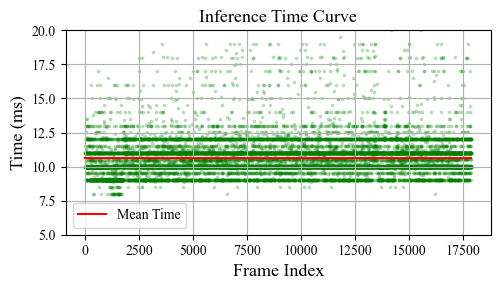

In [425]:
# plot the time curve
mean_time = np.mean(total_time_curves)
std_time = np.std(total_time_curves)
plt.figure(figsize=(5,3))
plt.grid()
plt.scatter(range(len(total_time_curves)),total_time_curves, s = 3, color = 'green',alpha=0.2)
#plot the mean time
plt.plot([0,len(total_time_curves)],[mean_time,mean_time],color = 'red',label = 'Mean Time')
plt.xlabel('Frame Index',fontsize = 13)
plt.ylabel('Time (ms)',fontsize = 13)
plt.title('Inference Time Curve',fontsize = 13)
plt.tight_layout()
plt.ylim(5,20)
plt.legend()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\inference_time_curve.png',dpi = 300)
plt.show()

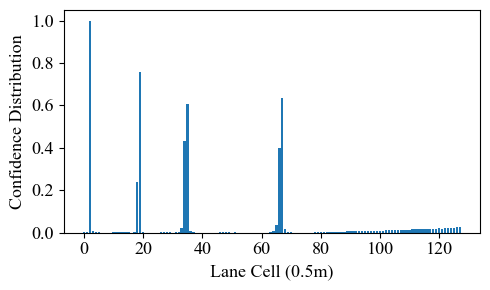

In [242]:
LOS_t = systhesis_diagram[lane_ind][:,3450]
LOS_t = LOS_t[:original_shapes[lane_ind][0]] / LOS_t.max()
# plot the LOS_t using bar plot
plt.figure(figsize=(5,3))
plt.bar(np.arange(len(LOS_t)),LOS_t)
plt.xlabel('Lane Cell (0.5m)',fontsize = 13)
plt.ylabel('Confidence Distribution',fontsize = 13)
# plt.title('LOS_t at Time t',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\LOS_t.png',dpi = 300)
plt.show()

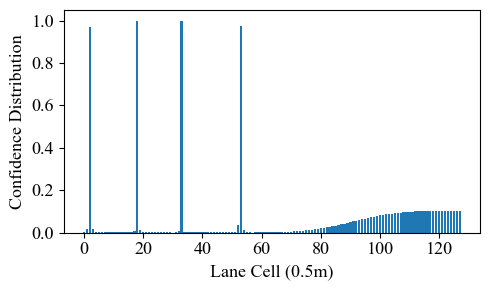

In [243]:
LOS_t = systhesis_diagram[lane_ind][:,3500]
LOS_t = LOS_t[:original_shapes[lane_ind][0]] / LOS_t.max()
# plot the LOS_t using bar plot
plt.figure(figsize=(5,3))
plt.bar(np.arange(len(LOS_t)),LOS_t)
plt.xlabel('Lane Cell (0.5m)',fontsize = 13)
plt.ylabel('Confidence Distribution',fontsize = 13)
# plt.title('LOS_t at Time t',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\LOS_t.png',dpi = 300)
plt.show()

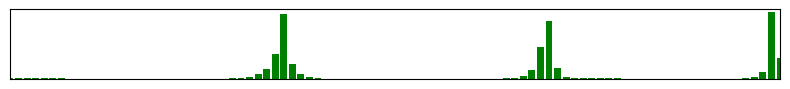

In [274]:
LOS_t = systhesis_diagram[lane_ind][:,4530]
LOS_t = LOS_t[:original_shapes[lane_ind][0]] / LOS_t.max()
# plot the LOS_t using bar plot
plt.figure(figsize=(8,1))
plt.bar(np.arange(len(LOS_t)),LOS_t, color = 'green')
# plt.xlabel('Lane Cell (0.5m)',fontsize = 13)
# plt.ylabel('Confidence Distribution',fontsize = 13)
# plt.title('LOS_t at Time t',fontsize = 13)
plt.xlim(0,90)
plt.xticks([],fontsize = 13)
plt.yticks([],fontsize = 13)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\LOS_t_8.png',dpi = 300)
plt.show()

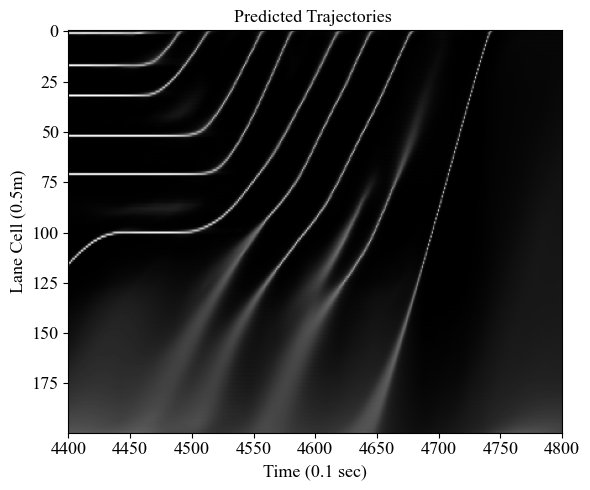

In [260]:
lane_ind = 2
# plot all pred_trajs
plt.figure(figsize=(6,5))
trajs_pred = pred_trajs[lane_ind]
plt.imshow(systhesis_diagram[lane_ind],cmap = 'gray',aspect = 'auto')
plt.xlim(4400,4800)
# plt.ylim(125,3)
plt.xlabel('Time (0.1 sec)',fontsize = 13)
plt.ylabel('Lane Cell (0.5m)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Predicted Trajectories ',fontsize = 13)
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\pred_traj.png',dpi = 300)
plt.show()

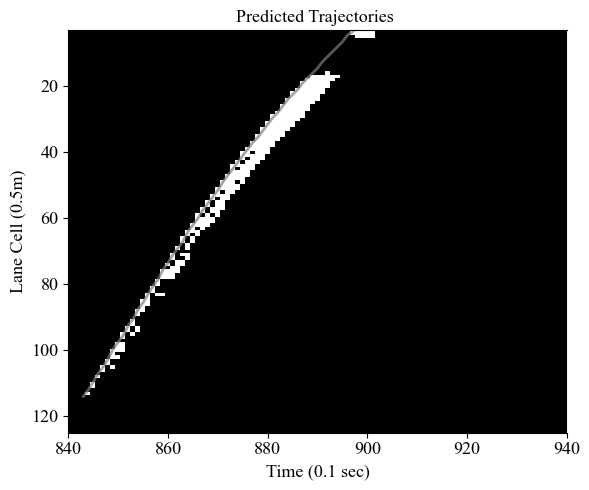

In [311]:
lane_ind = 5
# plot all pred_trajs
plt.figure(figsize=(6,5))
trajs_pred = pred_trajs[lane_ind]
plt.imshow(all_lane_diagrams[lane_ind],cmap = 'gray',aspect = 'auto')
for j,traj in enumerate(trajs_pred):
    t, x = zip(*traj)
    plt.plot(t,x, linewidth = 2,alpha = 0.7)
plt.xlim(840,940)
plt.ylim(125,3)
plt.xlabel('Time (0.1 sec)',fontsize = 13)
plt.ylabel('Lane Cell (0.5m)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Predicted Trajectories ',fontsize = 13)
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\pred_traj.png',dpi = 300)
plt.show()

In [ ]:
db = Raster_DBSCAN(Td_map_szie=test_diagram.shape, window_size=[11,19],eps = 1,min_samples=1)
trajs_pred = get_trajs_from_LSTM_out(test_diagram,conf_thred = 25,time_span = 100, lane_unit = 200)

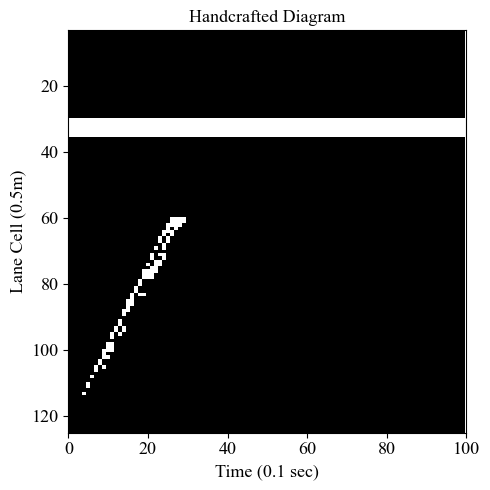

In [372]:
handcrafted_diagram = all_lane_diagrams[lane_ind][:,840:940].copy()
handcrafted_diagram[0:60] = 0
handcrafted_diagram[30:36] = 1
plt.figure(figsize=(5,5))
plt.imshow(handcrafted_diagram,cmap = 'gray',aspect = 'auto')
plt.xlim(0,100)
plt.ylim(125,3)
plt.xlabel('Time (0.1 sec)',fontsize = 13)
plt.ylabel('Lane Cell (0.5m)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Handcrafted Diagram',fontsize = 13)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\ProveCollective\handcrafted_diagram_15m.png',dpi = 300)
plt.show()


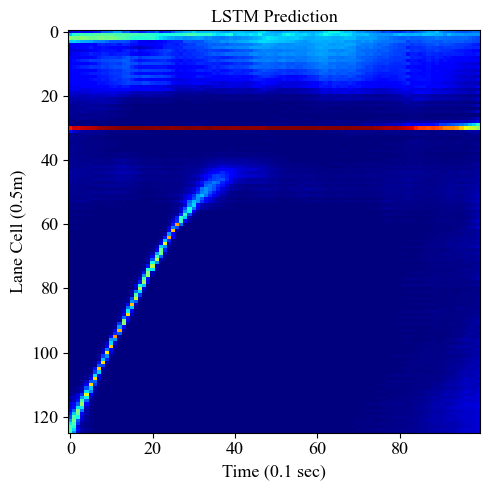

In [373]:
with torch.no_grad():
    handcrafted_diagram = torch.from_numpy(handcrafted_diagram).float().to(device)
    handcrafted_diagram = handcrafted_diagram.unsqueeze(0)
    output = best_model(handcrafted_diagram)
    output = output.squeeze(0).cpu().numpy()
    db = Raster_DBSCAN(Td_map_szie=output.shape, window_size=[11,19],eps = 1,min_samples=1)
    trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = 0.5,time_span = 100, lane_unit = 200)
handcrafted_diagram = handcrafted_diagram.cpu().numpy()[0]
plt.figure(figsize=(5,5))
plt.imshow(output,cmap = 'jet',aspect = 'auto')
plt.xlabel('Time (0.1 sec)',fontsize = 13)
plt.ylabel('Lane Cell (0.5m)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('LSTM Prediction',fontsize = 13)
plt.ylim(125)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\ProveCollective\lstm_prediction_15m.png',dpi = 300)
plt.show()

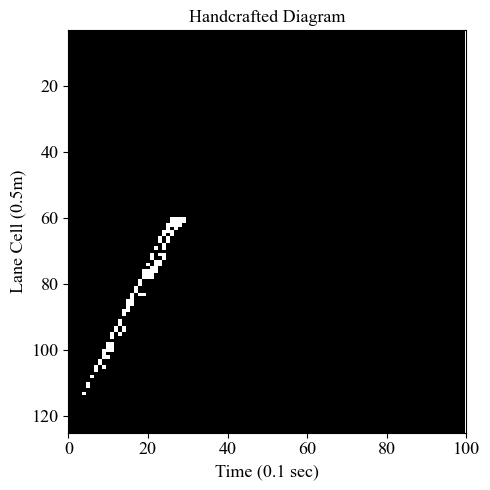

In [374]:
handcrafted_diagram = all_lane_diagrams[lane_ind][:,840:940].copy()
handcrafted_diagram[0:60] = 0

plt.figure(figsize=(5,5))
plt.imshow(handcrafted_diagram,cmap = 'gray',aspect = 'auto')
plt.xlim(0,100)
plt.ylim(125,3)
plt.xlabel('Time (0.1 sec)',fontsize = 13)
plt.ylabel('Lane Cell (0.5m)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Handcrafted Diagram',fontsize = 13)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\ProveCollective\handcrafted_diagram.png',dpi = 300)
plt.show()

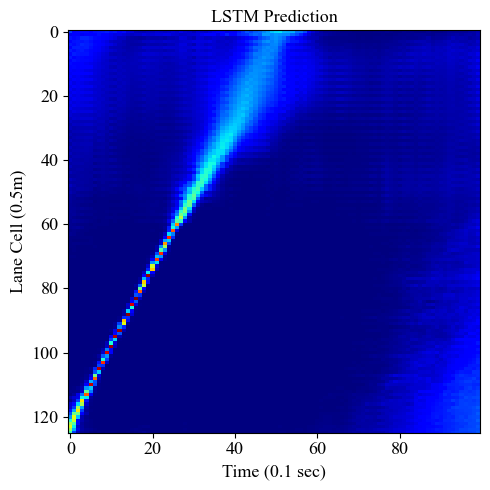

In [375]:
with torch.no_grad():
    handcrafted_diagram = torch.from_numpy(handcrafted_diagram).float().to(device)
    handcrafted_diagram = handcrafted_diagram.unsqueeze(0)
    output = best_model(handcrafted_diagram)
    output = output.squeeze(0).cpu().numpy()
    db = Raster_DBSCAN(Td_map_szie=output.shape, window_size=[11,19],eps = 1,min_samples=1)
    trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = 0.5,time_span = 100, lane_unit = 200)
handcrafted_diagram = handcrafted_diagram.cpu().numpy()[0]
plt.figure(figsize=(5,5))
plt.imshow(output,cmap = 'jet',aspect = 'auto')
plt.xlabel('Time (0.1 sec)',fontsize = 13)
plt.ylabel('Lane Cell (0.5m)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('LSTM Prediction',fontsize = 13)
plt.ylim(125)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\ProveCollective\lstm_prediction.png',dpi = 300)
plt.show()

In [183]:
def get_interpolated_traj(traj_pred):
    t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
    # drop duplicate time points
    t_pred, indices = np.unique(t_pred, return_index=True)
    x_pred = x_pred[indices]
    t_pred_max,t_pred_min = int(t_pred.max()),int(t_pred.min())
    t_pred_ = np.arange(t_pred_min,t_pred_max+1)
   
    # Interpolate label trajectory to match pred trajectory time points
    interp_func_pred = interp1d(t_pred, x_pred, fill_value="extrapolate")
    x_pred_interp = interp_func_pred(t_pred_)
    return np.c_[t_pred_, x_pred_interp]

In [184]:
from datetime import datetime
# what we want is: 1) volume 2) speed 3) acceleration 4) stopping time across all lanes in different time periods 
TrajDataFolder = r'D:\TimeSpaceDiagramDataset\9th&vir_314_pred'
TrajPredList = os.listdir(TrajDataFolder)
speed_window = 30
volumes_across_time = []
speed_acceleration_curve_across_time = []
stopping_time_across_time = []
date_list = []
for traj_file in tqdm(TrajPredList):
    traj = pd.read_csv(os.path.join(TrajDataFolder,traj_file))
    date = traj_file.split('.')[0].split('.')[0]
    # convert date to datetime for further analysis, date is in the format of YEAR-MONTH-DAY-HOUR-MIN-SEC
    date = datetime.strptime(date, '%Y-%m-%d-%H-%M-%S')
    date_list.append(date)
    # calculate volume by counting the number of unique traj_id that across at the distance of 10
    volume_lane = np.zeros(11) # we have in total 11 lanes
    speed_acceleration_curve_lane = {}
    for lane_ind in range(11):
        speed_acceleration_curve_lane[lane_ind] = []
    stopping_sec_lane = np.zeros(11)
    # group by lane and TrajID
    traj_grouped = traj.groupby(['Lane','TrajID'])
    for (lane_ind,TrajID),traj_pred in traj_grouped:
        if_cross_stop_bar = traj_pred.LaneCell.max() > 5 and traj_pred.LaneCell.min() < 5
        if if_cross_stop_bar:
            volume_lane[lane_ind] += 1
        if len(traj_pred) < speed_window:
            continue
        speed_curve = []
        acceleration_curve = []
        t_x_values = np.array(traj_pred[['Time','LaneCell']])
        # sort the t_x_values by time
        t_x_values = t_x_values[t_x_values[:,0].argsort()]
        # interpolate t_x_values to get the speed and acceleration
        t_x_values_interp = get_interpolated_traj(t_x_values)
        for k in range(len(t_x_values_interp)-speed_window):
            speed_k = (t_x_values_interp[k+speed_window//2,1] - t_x_values_interp[k + speed_window,1]) * 0.5 / (speed_window//2 /10)
            speed_half = (t_x_values_interp[k,1] - t_x_values_interp[k+speed_window//2,1] ) * 0.5 / (speed_window//2 /10)
            speed_curve.append(speed_k)
            acceleration = (speed_k - speed_half) / (speed_window//2 /10)
            acceleration_curve.append(acceleration)
        speed_curve = np.array(speed_curve)
        acceleration_curve = np.array(acceleration_curve)
        # concatenate the speed_curve and acceleration_curve to the t_x_values_interp
        t_x_values_interp = np.c_[t_x_values_interp[:-speed_window],speed_curve,acceleration_curve]
        t_x_values_interp[:,1] = t_x_values_interp[:,1] * 0.5
        # t (0.1sec), x (m), speed (m/s), acceleration (m/s^2)
        speed_acceleration_curve_lane[lane_ind].append(t_x_values_interp)
        if if_cross_stop_bar:
            stopping_sec = ((t_x_values_interp[:,2] < 1) & (t_x_values_interp[:,2] > -1)).sum() * 0.1
            stopping_sec_lane[lane_ind] += stopping_sec
    volumes_across_time.append(volume_lane)
    speed_acceleration_curve_across_time.append(speed_acceleration_curve_lane)
    stopping_time_across_time.append(stopping_sec_lane)


100%|██████████| 49/49 [00:16<00:00,  2.99it/s]


In [ ]:
import geopandas as gpd
from datetime import timedelta

traj_file = TrajPredList[1]
lane_gdf = gpd.read_file(r'./lane_gdf.shp')
lane_gdf['mean_speed'] = 0
lane_gdf['mean_acceleration'] = 0
# traj_file = TrajPredList[1]
traj = pd.read_csv(os.path.join(TrajDataFolder,traj_file))
date = traj_file.split('.')[0].split('.')[0]
print(date,traj_file)
# convert date to datetime for further analysis, date is in the format of YEAR-MONTH-DAY-HOUR-MIN-SEC
date = datetime.strptime(date, '%Y-%m-%d-%H-%M-%S')
# convert from UTC to pacific time
date = date - timedelta(hours = 7)
# convert back to string
date = date.strftime('%Y-%m-%d-%H-%M-%S')

# date_list.append(date)
# calculate volume by counting the number of unique traj_id that across at the distance of 10
volume_lane = np.zeros(11) # we have in total 11 lanes
speed_acceleration_curve_lane = {}
for lane_ind in range(11):
    speed_acceleration_curve_lane[lane_ind] = []
stopping_sec_lane = np.zeros(11)
# group by lane and TrajID
traj_grouped = traj.groupby(['Lane','TrajID'])
traj_dic = {}
for _ in range(11):
    traj_dic[_] = []
for (lane_ind,TrajID),traj_pred in traj_grouped:
    traj_dic[lane_ind].append(traj_pred)
# plot all trajectories in 11 lanes using (11,1) subplot, and use color to represent the speed
fig, axs = plt.subplots(11,1,figsize=(5,15))




In [208]:
import geopandas as gpd
from datetime import timedelta
for traj_file in TrajPredList:
    lane_gdf = gpd.read_file(r'./lane_gdf.shp')
    lane_gdf['mean_speed'] = 0
    lane_gdf['mean_acceleration'] = 0
    # traj_file = TrajPredList[1]
    traj = pd.read_csv(os.path.join(TrajDataFolder,traj_file))
    date = traj_file.split('.')[0].split('.')[0]
    print(date,traj_file)
    # convert date to datetime for further analysis, date is in the format of YEAR-MONTH-DAY-HOUR-MIN-SEC
    date = datetime.strptime(date, '%Y-%m-%d-%H-%M-%S')
    # convert from UTC to pacific time
    date = date - timedelta(hours = 7)
    # convert back to string
    date = date.strftime('%Y-%m-%d-%H-%M-%S')

    # date_list.append(date)
    # calculate volume by counting the number of unique traj_id that across at the distance of 10
    volume_lane = np.zeros(11) # we have in total 11 lanes
    speed_acceleration_curve_lane = {}
    for lane_ind in range(11):
        speed_acceleration_curve_lane[lane_ind] = []
    stopping_sec_lane = np.zeros(11)
    # group by lane and TrajID
    traj_grouped = traj.groupby(['Lane','TrajID'])
    for (lane_ind,TrajID),traj_pred in traj_grouped:
        if_cross_stop_bar = traj_pred.LaneCell.max() > 5 and traj_pred.LaneCell.min() < 5
        if if_cross_stop_bar:
            volume_lane[lane_ind] += 1
        if len(traj_pred) < speed_window:
            continue
        speed_curve = []
        acceleration_curve = []
        t_x_values = np.array(traj_pred[['Time','LaneCell']])
        # sort the t_x_values by time
        t_x_values = t_x_values[t_x_values[:,0].argsort()]
        # interpolate t_x_values to get the speed and acceleration
        t_x_values_interp = get_interpolated_traj(t_x_values)
        for k in range(len(t_x_values_interp)-speed_window):
            speed_k = (t_x_values_interp[k+speed_window//2,1] - t_x_values_interp[k + speed_window,1]) * 0.5 / (speed_window//2 /10)
            speed_half = (t_x_values_interp[k,1] - t_x_values_interp[k+speed_window//2,1] ) * 0.5 / (speed_window//2 /10)
            speed_curve.append(speed_k)
            acceleration = (speed_k - speed_half) / (speed_window//2 /10)
            acceleration_curve.append(acceleration)
        speed_curve = np.array(speed_curve)
        acceleration_curve = np.array(acceleration_curve)
        # concatenate the speed_curve and acceleration_curve to the t_x_values_interp
        t_x_values_interp = np.c_[t_x_values_interp[:-speed_window],speed_curve,acceleration_curve]
        t_x_values_interp[:,1] = t_x_values_interp[:,1] * 0.5
        speed_acceleration_curve_lane[lane_ind].append(t_x_values_interp)

    lane_gdf_ = []
    for lane_ind in range(11):
        single_lane_gdf = lane_gdf.loc[lane_gdf.lane_id == lane_ind]
        if len(speed_acceleration_curve_lane[lane_ind]) == 0:
            # add np.nan to the mean_speed and mean_acceleration
            single_lane_gdf.loc[:,'mean_speed'] = np.nan
            single_lane_gdf.loc[:,'mean_acceleration'] = np.nan
            lane_gdf_.append(single_lane_gdf)
            continue
        lane_speed_accel = np.concatenate(speed_acceleration_curve_lane[lane_ind],axis = 0)
        lane_speed = lane_speed_accel[:,2]
        lane_acceleration = lane_speed_accel[:,3]
        lane_x = lane_speed_accel[:,1]
        lane_cell_ind = np.floor((lane_x / 0.5))
        
        
        # use lane_cell_ind to map corresponding lane_cell, and calculate the average speed and acceleration
        lane_speed_avg = []
        lane_acceleration_avg = []
        for i in range(len(single_lane_gdf)):
            mask = (len(single_lane_gdf) - lane_cell_ind) == i
            if mask.sum() == 0:
                lane_speed_avg.append(np.nan)
                lane_acceleration_avg.append(np.nan)
                continue
            lane_speed_avg.append(lane_speed[mask].mean())
            lane_acceleration_avg.append(lane_acceleration[mask].mean())
        lane_speed_avg = np.array(lane_speed_avg)
        lane_acceleration_avg = np.array(lane_acceleration_avg)
        mask = np.isnan(lane_speed_avg)
        lane_speed_avg[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), lane_speed_avg[~mask])
        mask = np.isnan(lane_acceleration_avg)
        lane_acceleration_avg[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), lane_acceleration_avg[~mask])
        # fill the mean_speed and mean_acceleration to the single_lane_gdf using .loc
        single_lane_gdf.loc[:,'mean_speed'] = lane_speed_avg
        single_lane_gdf.loc[:,'mean_acceleration'] = lane_acceleration_avg
        lane_gdf_.append(single_lane_gdf)
    lane_gdf_ = pd.concat(lane_gdf_)

    background_point_cloud = get_pcd_colored(thred_map.max(axis = 0),thred_map.max(axis = 0) > 0,[0,32])
    # plot the lane_gdf_ using mean_speed to represent different color
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # plot the background point cloud
    ax.scatter(background_point_cloud[0][:,0],background_point_cloud[0][:,1],c = 'gray',s = 1,alpha=0.5)
    lane_gdf_.plot(column='mean_speed', ax=ax, legend=True, cmap='jet',vmin = 0, vmax = 15)
    # adjust the colorbar, use 20 as the maximum speed

    # annotate the lane_id
    for lane_ind in range(11):
        x = lane_gdf_[lane_gdf_.lane_id == lane_ind].geometry.centroid.x.values[-50]
        y = lane_gdf_[lane_gdf_.lane_id == lane_ind].geometry.centroid.y.values[-50]
        # bold the lane_id, make them more readable and let them away from each other
        ax.text(x,y,f'{lane_ind}',fontsize = 13,weight = 'bold')
    ax.set_xlim(-65,65)
    ax.set_ylim(-45,95)
    ax.set_title(f'{date}',fontsize = 15)
    # convert date to Year-Month-Day-Hour-Min-Sec
    plt.tight_layout()
    plt.savefig(os.path.join('D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\Speed',f'{date}.png'),dpi = 300)
    plt.close()

2024-03-14-19-30-00 2024-03-14-19-30-00.csv
2024-03-14-20-00-00 2024-03-14-20-00-00.csv
2024-03-14-20-30-00 2024-03-14-20-30-00.csv
2024-03-14-21-00-00 2024-03-14-21-00-00.csv
2024-03-14-21-30-00 2024-03-14-21-30-00.csv
2024-03-14-22-00-00 2024-03-14-22-00-00.csv
2024-03-14-22-30-00 2024-03-14-22-30-00.csv
2024-03-14-23-00-00 2024-03-14-23-00-00.csv
2024-03-14-23-30-00 2024-03-14-23-30-00.csv
2024-03-15-00-00-00 2024-03-15-00-00-00.csv
2024-03-15-00-30-00 2024-03-15-00-30-00.csv
2024-03-15-01-00-00 2024-03-15-01-00-00.csv
2024-03-15-01-30-00 2024-03-15-01-30-00.csv
2024-03-15-02-00-00 2024-03-15-02-00-00.csv
2024-03-15-02-30-00 2024-03-15-02-30-00.csv
2024-03-15-03-00-00 2024-03-15-03-00-00.csv
2024-03-15-03-30-00 2024-03-15-03-30-00.csv
2024-03-15-04-00-00 2024-03-15-04-00-00.csv
2024-03-15-04-30-00 2024-03-15-04-30-00.csv
2024-03-15-05-00-00 2024-03-15-05-00-00.csv
2024-03-15-05-30-00 2024-03-15-05-30-00.csv
2024-03-15-06-00-00 2024-03-15-06-00-00.csv
2024-03-15-06-30-00 2024-03-15-0

In [96]:
lane_gdf_ = []
for lane_ind in range(11):
    lane_speed_accel = np.concatenate(speed_acceleration_curve_lane[lane_ind],axis = 0)
    lane_speed = lane_speed_accel[:,2]
    lane_acceleration = lane_speed_accel[:,3]
    lane_x = lane_speed_accel[:,1]
    lane_cell_ind = np.floor((lane_x / 0.5))
    
    single_lane_gdf = lane_gdf.loc[lane_gdf.lane_id == lane_ind]
    # use lane_cell_ind to map corresponding lane_cell, and calculate the average speed and acceleration
    lane_speed_avg = []
    lane_acceleration_avg = []
    for i in range(len(single_lane_gdf)):
        mask = (len(single_lane_gdf) - lane_cell_ind) == i
        if mask.sum() == 0:
            lane_speed_avg.append(np.nan)
            lane_acceleration_avg.append(np.nan)
            continue
        lane_speed_avg.append(lane_speed[mask].mean())
        lane_acceleration_avg.append(lane_acceleration[mask].mean())
    # interpolate the lane_speed and lane_acceleration to fill the nan values
    lane_speed_avg = np.array(lane_speed_avg)
    lane_acceleration_avg = np.array(lane_acceleration_avg)
    mask = np.isnan(lane_speed_avg)
    lane_speed_avg[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), lane_speed_avg[~mask])
    mask = np.isnan(lane_acceleration_avg)
    lane_acceleration_avg[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), lane_acceleration_avg[~mask])
    
    # fill the mean_speed and mean_acceleration to the single_lane_gdf using .loc

    single_lane_gdf.loc[:,'mean_speed'] = lane_speed_avg
    single_lane_gdf.loc[:,'mean_acceleration'] = lane_acceleration_avg
    lane_gdf_.append(single_lane_gdf)
lane_gdf_ = pd.concat(lane_gdf_)

In [83]:
thred_map = np.load('../thred_map.npy')
def calc_timing_offsets():
    timing_offsets = np.zeros((32,12))  # Init matrix
    # constants
    full_firing_cycle = 55.296  # μs
    single_firing = 2.304  # μs
    # compute timing offsets
    for x in range(12):
        for y in range(32):
            dataBlockIndex = (x * 2) + int((y / 16))
            dataPointIndex = y % 16
            timing_offsets[y][x] = (full_firing_cycle * dataBlockIndex) +(single_firing * dataPointIndex)

    return np.array(timing_offsets).T
Data_order = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                            [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                            [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                            [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                            [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                            [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                            [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                            [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                            ])
laser_id = np.full((32,12),np.arange(32).reshape(-1,1).astype('int'))
timing_offset = calc_timing_offsets()
omega = Data_order[:,0]
theta = np.sort(omega)
azimuths = np.arange(0,360,0.2)
arg_omega = np.argsort(omega)
def get_pcd_colored(Td_map,Labeling_map,vertical_limits):

    Xs = []
    Ys = []
    Labels = []
    for i in range(vertical_limits[0],vertical_limits[1]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = Td_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Xs.append(X)
        Ys.append(Y)
        Labels.append(Labeling_map[i])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Labels = np.concatenate(Labels)
    XYZ = np.c_[Xs,Ys]
    Valid_ind = (XYZ[:,0] != 0)&(XYZ[:,1] != 0)
    Labels = Labels[Valid_ind]
    XYZ = XYZ[Valid_ind]

    return XYZ,Labels    

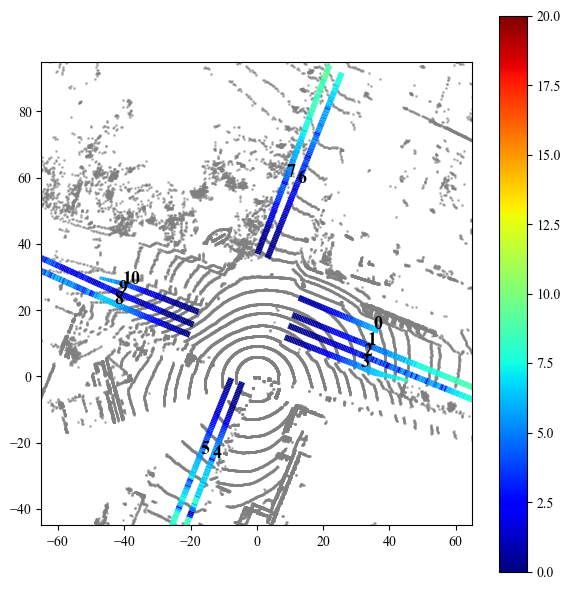

In [206]:
background_point_cloud = get_pcd_colored(thred_map.max(axis = 0),thred_map.max(axis = 0) > 0,[0,32])
# plot the lane_gdf_ using mean_speed to represent different color
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plot the background point cloud
im = ax.scatter(background_point_cloud[0][:,0],background_point_cloud[0][:,1],c = 'gray',s = 1,alpha=0.5)
lane_gdf_.plot(column='mean_speed', ax=ax, legend=True, cmap='jet',vmin = 0, vmax = 20)
# make color bar to align with the graph height
# annotate the lane_id
for lane_ind in range(11):
    x = lane_gdf_[lane_gdf_.lane_id == lane_ind].geometry.centroid.x.values[-50]
    y = lane_gdf_[lane_gdf_.lane_id == lane_ind].geometry.centroid.y.values[-50]
    # bold the lane_id, make them more readable and let them away from each other
    ax.text(x,y,f'{lane_ind}',fontsize = 13,weight = 'bold')
ax.set_xlim(-65,65)
ax.set_ylim(-45,95)

plt.tight_layout()
plt.show()

In [103]:
from datetime import timedelta
date_list = []
for traj_file in tqdm(TrajPredList):
    # traj = pd.read_csv(os.path.join(TrajDataFolder,traj_file))
    date = traj_file.split('.')[0].split('.')[0]
    # convert date to datetime for further analysis, date is in the format of YEAR-MONTH-DAY-HOUR-MIN-SEC
    date = datetime.strptime(date, '%Y-%m-%d-%H-%M-%S')
    date_list.append(date)
# convert date_list from UTC to pacific time and only keep the hour and minute
date_list = [date - timedelta(hours=7) for date in date_list]
date_list = [date.strftime('%H:%M') for date in date_list]

100%|██████████| 49/49 [00:00<?, ?it/s]


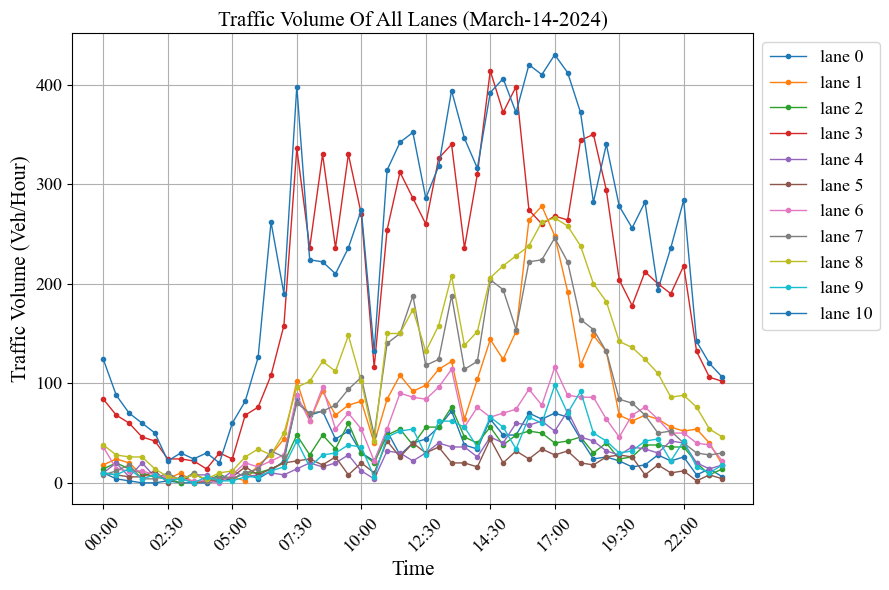

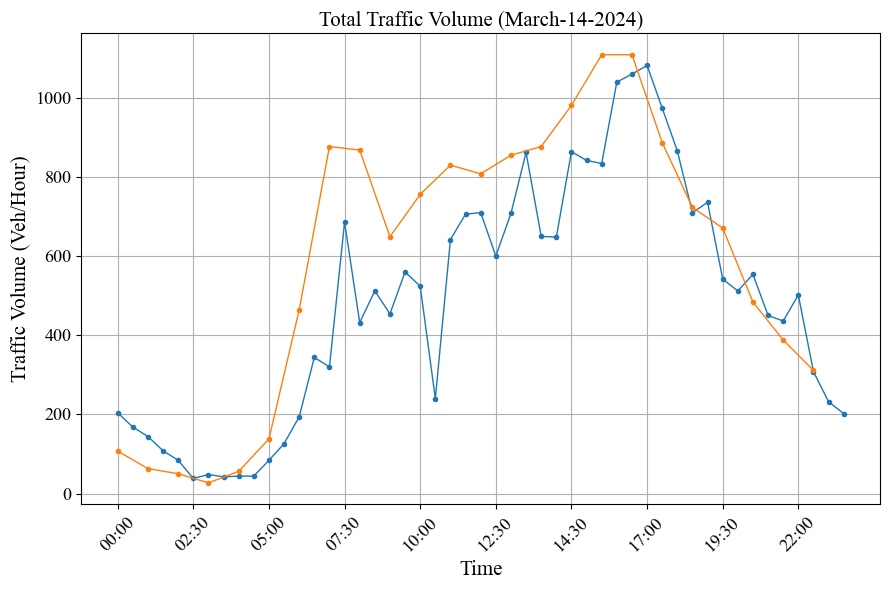

In [115]:
# plot volume across time
volumes_across_time = np.array(volumes_across_time)
# soort the date_list and volumes_across_time
date_list = np.array(date_list)
sort_ind = np.argsort(date_list)
date_list = date_list[sort_ind]
volumes_across_time = volumes_across_time[sort_ind]
plt.figure(figsize=(9,6))
plt.grid()
for i in range(11):
    plt.plot(volumes_across_time[:,i] * 2,label = f'lane {i}', linewidth = 1, marker = 'o', markersize = 3)
plt.xlabel('Time',fontsize = 15)
plt.ylabel('Traffic Volume (Veh/Hour)',fontsize = 15)
plt.title('Traffic Volume Of All Lanes (March-14-2024)',fontsize = 15)
plt.xticks( np.arange(len(date_list))[::5],date_list[::5],rotation = 45,fontsize = 13)
plt.yticks(fontsize = 13)
# plot legend outside the plot
plt.legend(loc='upper left',bbox_to_anchor=(1, 1),fontsize = 13)
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\VolumeAcrossTime.png',dpi = 300)
plt.show()
# plot total volume across all lanes
plt.figure(figsize=(9,6))
plt.grid()
plt.plot(volumes_across_time[:,[1,2,8,9,10]].sum(axis = 1) * 2,label = 'Total Volume', linewidth = 1, marker = 'o', markersize = 3)
# from 00:00 to 23:00, we have 24 hours in one hour period
ground_truth_NS_Volume = [107, 63,50,27,56,138,464,877,868,649,756,830,808,855,877,981,1109,1109,887,723,671,484,388,311]
ground_truth_NS_Volume = np.array(ground_truth_NS_Volume)
# plot this ground truth volume, note that it's interval is one hour, but ours is 30 minutes
plt.plot(np.arange(0,48,2),ground_truth_NS_Volume,label = 'Ground Truth Volume', linewidth = 1, marker = 'o', markersize = 3)
plt.xlabel('Time',fontsize = 15)
plt.ylabel('Traffic Volume (Veh/Hour)',fontsize = 15)
plt.title('Total Traffic Volume (March-14-2024)',fontsize = 15)
plt.xticks( np.arange(len(date_list))[::5],date_list[::5],rotation = 45,fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\TotalVolumeAcrossTime.png',dpi = 300)
plt.show()


In [209]:
1770.28/3600

0.49174444444444443

C:\Users\zhChe\AppData\Local\Temp\ipykernel_10020\1823839958.py:1: RuntimeWarning: invalid value encountered in divide
  delay_across_time = np.array(stopping_time_across_time) / np.array(volumes_across_time)


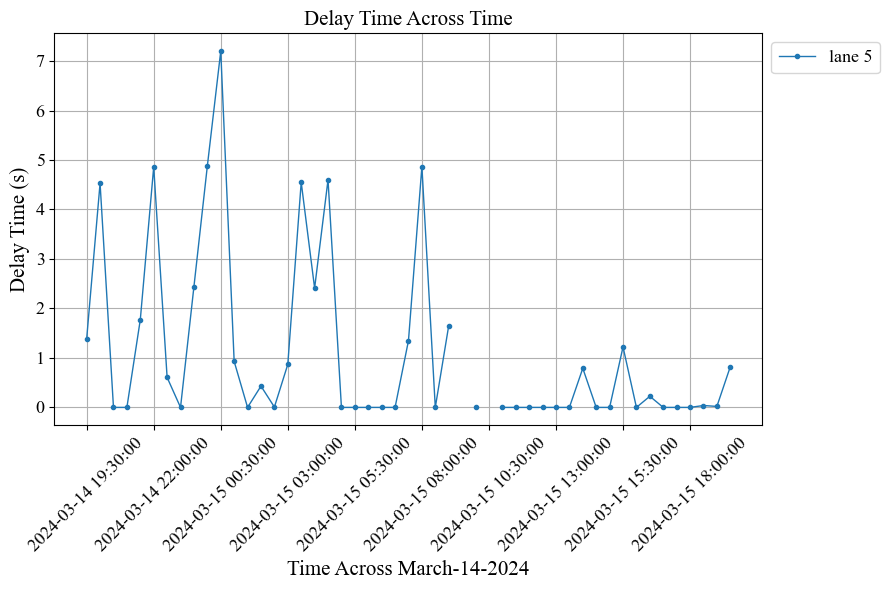

In [315]:
delay_across_time = np.array(stopping_time_across_time) / np.array(volumes_across_time)
plt.figure(figsize=(9,6))
plt.grid()
# for i in range(11):
i = 5
plt.plot(delay_across_time[:,i],label = f'lane {i}', linewidth = 1, marker = 'o', markersize = 3)
plt.xlabel('Time Across March-14-2024',fontsize = 15)
plt.ylabel('Delay Time (s)',fontsize = 15)
plt.title('Delay Time Across Time',fontsize = 15)
plt.xticks( np.arange(len(date_list))[::5],date_list[::5],rotation = 45,fontsize = 13)
plt.yticks(fontsize = 13)
# plot legend outside the plot
plt.legend(loc='upper left',bbox_to_anchor=(1, 1),fontsize = 13)
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\DelayTimeAcrossTime.png',dpi = 300)
plt.show()

In [303]:
mean_speeds_across_time = []
mean_accelerations_across_time = []

for dic in speed_acceleration_curve_across_time:
    mean_speeds = np.zeros(11)
    mean_accelerations = np.zeros(11)
    for key in dic.keys():
        if len(dic[key]) == 0:
            continue
        speed_acceleration_records = np.concatenate(dic[key],axis = 0)
        mean_speed = speed_acceleration_records[:,2].mean()
        mean_acceleration = speed_acceleration_records[:,3].mean()
        mean_speeds[key] = mean_speed
        mean_accelerations[key] = mean_acceleration
    mean_speeds_across_time.append(mean_speeds)
    mean_accelerations_across_time.append(mean_accelerations)

In [305]:
mean_speeds_across_time = np.array(mean_speeds_across_time)
mean_accelerations_across_time = np.array(mean_accelerations_across_time)

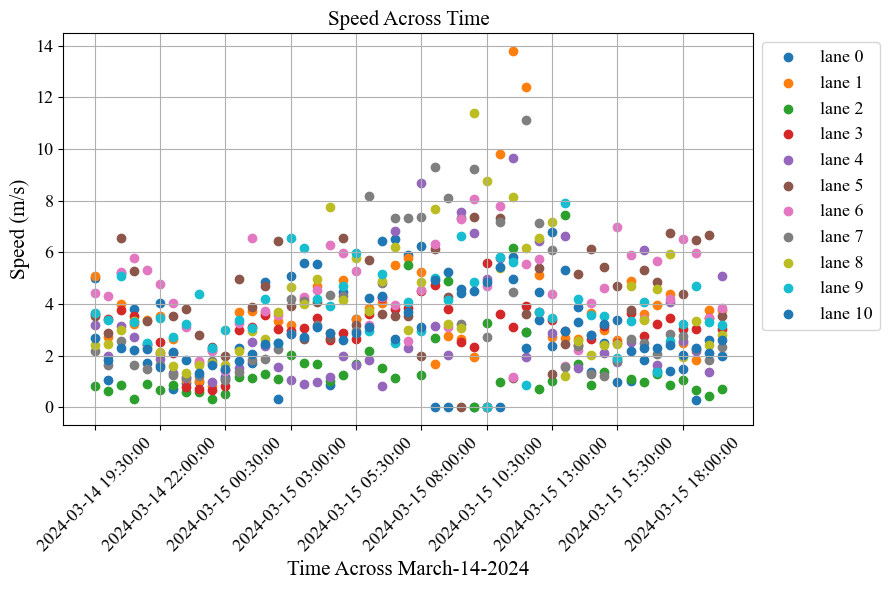

In [312]:
# plot speed across time
plt.figure(figsize=(9,6))
plt.grid()
for i in range(11):
    plt.scatter(np.arange(len(mean_speeds_across_time[:,i])),mean_speeds_across_time[:,i],label = f'lane {i}', marker = 'o')
plt.xlabel('Time Across March-14-2024',fontsize = 15)
plt.ylabel('Speed (m/s)',fontsize = 15)
plt.title('Speed Across Time',fontsize = 15)
plt.xticks( np.arange(len(date_list))[::5],date_list[::5],rotation = 45,fontsize = 13)
plt.yticks(fontsize = 13)
# plot legend outside the plot
plt.legend(loc='upper left',bbox_to_anchor=(1, 1),fontsize = 13)
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\SpeedAcrossTime.png',dpi = 300)
plt.show()

### OBD

In [382]:
OBD_data = pd.read_excel(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\LiDAR Data.xlsx')

In [388]:
g.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'OBJECTID_1 *', 'Shape *',
       'index', 'Timestamp', 'ObjectID', 'FrameIndex', 'PredInd', 'Coord_X',
       'Coord_Y', 'Coord_Z', 'Speed_X', 'Speed_Y', 'Speed', 'Longitude',
       'Latitude', 'Elevation', 'Point_Cnt', 'Dir_X_Bbox', 'Dir_Y_Bbox',
       'Height', 'Length', 'Width', 'Area', 'Dis', 'Max_Length', 'Class',
       'NewObjectID', 'MoveAngle', 'DateTime', 'AdjSpeed', 'MedianSpeed',
       'Acceleration', 'Speed(mph)', 'FrameIndex.1', 'ObjectID.1',
       'OBDSpeed (mph)'],
      dtype='object')

In [394]:
speed_errrors = []
for ojd_id,g in OBD_data.groupby('ObjectID.1'):
    coords = np.array(g.loc[:,['Coord_X','Coord_Y']]) # in meter
    # calculate speed (m/s) using the coords
    speed = np.linalg.norm(coords[1:] - coords[:-1],axis = 1) / 0.1
    obd_speed = np.array(g.loc[:,'OBDSpeed (mph)']) # mph
    # convert mph to m/s
    obd_speed = obd_speed * 0.44704
    speed_error = speed - obd_speed[1:]
    speed_errrors.append(speed_error)
speed_errrors = np.concatenate(speed_errrors)
    

In [398]:
speed_errrors.std()

4.253198793884175

In [397]:
speed_errrors.mean()

0.8081803312832752

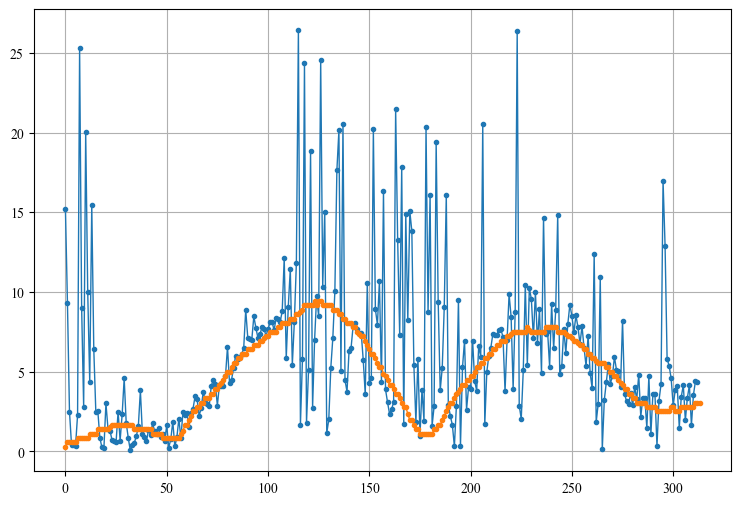

In [392]:
plt.figure(figsize=(9,6))
plt.grid()
plt.plot(speed,label = 'Calculated Speed', linewidth = 1, marker = 'o', markersize = 3)
plt.plot(obd_speed,label = 'OBD Speed', linewidth = 1, marker = 'o', markersize = 3)